## Development notebook for `build_predictions()` and `build_heatmap()`


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../')
import tensorflow as tf
import keras.backend as KB

import numpy as np
import skimage.io
import mrcnn.visualize as visualize
import mrcnn.utils as utils
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.callbacks       import get_layer_output_1,get_layer_output_2
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.visualize       import display_instances_with_mask,display_training_batch
from mrcnn.prep_notebook   import mrcnn_coco_test, mrcnn_coco_train, prep_coco_dataset
# from mrcnn.utils           import log
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

mrcnn_model, mrcnn_config = mrcnn_coco_train(mode = 'trainfcn', batch_sz=1)


Using TensorFlow backend.


>>> Initialize Paths
 windows  Windows

Paths:
-------------------------
COCO_DATASET_PATH              F:\MLDatasets\coco2014
COCO_HEATMAP_PATH              F:\MLDatasets\coco2014_heatmaps
COCO_MODEL_PATH                F:\PretrainedModels\mask_rcnn_coco.h5
DIR_DATASET                    F:\MLDatasets
DIR_PRETRAINED                 F:\PretrainedModels
DIR_ROOT                       F:\
DIR_TRAINING                   F:\models
FCN_TRAINING_PATH              F:\models\train_fcn_coco
FCN_VGG16_MODEL_PATH           F:\PretrainedModels\fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5
MRCNN_TRAINING_PATH            F:\models\train_mrcnn_coco
RESNET_MODEL_PATH              F:\PretrainedModels\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
VGG16_MODEL_PATH               F:\PretrainedModels\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


>>> Initialize ModelBase model 
   Mode      :  trainfcn
   Model dir :  F:\models\train_mrcnn_coco
>>> ModelBase initialiation complete
>>> ---Initi

    prob_grid_clipped      :  (?, 256, 256)
    scores_scattered shape :  (1, 81, 200, 3)
    gauss_scores           :  (1, 81, 200, 11)  Name:    cntxt_layer_gt/gt_heatmap_scores:0
    gauss_scores  (FINAL)  :  (1, 81, 200, 11)  Keras tensor  False

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 256, 256)
    gauss_heatmap   :  (1, 81, 200, 256, 256)

    Reduce MAX based on class ---------------------------------------------
    gaussian_heatmap :  (1, 81, 256, 256) Keras tensor  False
    gauss_heatmap :  (1, 256, 256, 81)  Keras tensor  False

    gt_heatmap                  :  (1, 256, 256, 81) Keras tensor  False
    gt_heatmap_scores           :  (1, 81, 200, 11) Keras tensor  False
    complete
<<<  shape of pred_heatmap   :  (1, 256, 256, 81)  Keras tensor  True
<<<  shape of gt_heatmap     :  (1, 256, 256, 81)  Keras tensor  True

>>> Build MaskRCNN build complete. mode:  trainfcn
>>> MaskRC

####  Load Model Weights

In [2]:
# exclude=["mrcnn_class_logits"] # ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
mrcnn_model.load_model_weights(init_with = 'last', exclude = None)  

-----------------------------------------------
 Load Model with init parm: [ last ]
-----------------------------------------------
 ---> last
>>> find_last checkpoint in :  F:\models\train_mrcnn_coco
    Dir starting with  mrcnn  : ['mrcnn20181011T1100', 'mrcnn20181024T2023', 'mrcnn20181111T1438', 'mrcnn20181111T1441', 'mrcnn20181112T1039', 'mrcnn20181112T1531', 'mrcnn20181113T1636', 'mrcnn20181113T1654', 'mrcnn20181113T2154', 'mrcnn20181113T2235', 'mrcnn20181113T2259', 'mrcnn20181114T1203', 'mrcnn20181114T1204', 'mrcnn20181114T1454', 'mrcnn20181115T1017', 'mrcnn20181115T1041', 'mrcnn20181115T1114', 'mrcnn20181115T1259', 'mrcnn20181115T1503', 'mrcnn20181115T1645', 'mrcnn20181115T2042', 'mrcnn20181115T2159', 'mrcnn20181116T1221', 'mrcnn20181118T1310']
    find_last():   dir_name: F:\models\train_mrcnn_coco\mrcnn20181011T1100
    find_last(): checkpoint: F:\models\train_mrcnn_coco\mrcnn20181011T1100\mrcnn_0103.h5
>>> load_weights() from : F:\models\train_mrcnn_coco\mrcnn20181011T1100\m

#### List trainable layers using `get_trainable_layers()` 

In [ ]:
for i in  mrcnn_model.get_trainable_layers():
    print(' Layer:', i.name)    

## Display Images

In [77]:

##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
## train  : 82081 |  train + val35k : 117266
## val35k : 35185 |
## minival:  4952
## val    : 40137
#   'accessory':   [27, 28, 31, 32, 33],
#   'animal':     [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
#
#   'appliance':  [78, 79, 80, 81, 82],
#   'background': [0],
#   'electronic': [72, 73, 74, 75, 76, 77],
#   'food':       [52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
#   'furniture':  [62, 63, 64, 65, 67, 70],
#   'indoor':     [84, 85, 86, 87, 88, 89, 90],
#   'kitchen':    [44, 46, 47, 48, 49, 50, 51],
#   'outdoor':    [10, 11, 13, 14, 15],
#   'person':     [1],
#   'sports':     [34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
#   'vehicle':    [2, 3, 4, 5, 6, 7, 8, 9]} 
##------------------------------------------------------------------------------------
load_class_ids = [62,63,64,65,67,70, 44,46,47,48,49,50,51,  72,73,74,75,76,77 , 82,61]
dataset_train, train_generator = prep_coco_dataset(["train", 'val35k'], mrcnn_config, generator = True, return_coco =True, active_class_ids=load_class_ids)
# dataset_val, val_generator   = prep_coco_dataset(["minival"], mrcnn_config, generator = True)

COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_train2014.json  into memory...
Done (t=21.17s)
creating index...
index created!
 load subset of classes:  [62, 63, 64, 65, 67, 70, 44, 46, 47, 48, 49, 50, 51, 72, 73, 74, 75, 76, 77, 82, 61]
 image dir            :  F:\MLDatasets\coco2014\train2014
 json_path_dir        :  F:\MLDatasets\coco2014\annotations/instances_train2014.json
 number of images     :  30813
 image_ids[:10]       :  [131074, 131075, 9, 262159, 524311, 524314, 262172, 30, 393251, 262180]
 image_ids[1000:1010] :  [266200, 4057, 528344, 4065, 266209, 528355, 397286, 528358, 397292, 135149]
COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_valminusminival2014.json  into memory...
Done (t=6.04s)
creating index...
index created!
 load subset of classes:  [62, 63, 64, 65, 67, 70, 44, 46, 47, 48, 49, 50, 51, 72, 73, 74, 75, 76, 77, 82, 61]
 image dir            :  F:\MLDatasets\coco2014\val2014
 json_path_dir        :  F:\ML

In [80]:
print(dataset_train.active_class_ids)
pp.pprint(dataset_train.category_to_class_map)
pp.pprint(dataset_train.category_to_external_class_map)
print(' dataset_train.source_objs:   ',dataset_train.source_objs)
print(' len of dataset_train.image_info: ', len(dataset_train.image_info))
print(dataset_train.image_info[0].keys())
for i in range(10):
    p = dataset_train.image_info[i]
    print(i,p['id'], p['source'], p['path'])

[44, 46, 47, 48, 49, 50, 51, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 82]
{ 'accessory': [25, 26, 27, 28, 29],
  'animal': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
  'appliance': [69, 70, 71, 72, 73],
  'background': [0],
  'electronic': [63, 64, 65, 66, 67, 68],
  'food': [47, 48, 49, 50, 51, 52, 53, 54, 55, 56],
  'furniture': [57, 58, 59, 60, 61, 62],
  'indoor': [74, 75, 76, 77, 78, 79, 80],
  'kitchen': [40, 41, 42, 43, 44, 45, 46],
  'outdoor': [10, 11, 12, 13, 14],
  'person': [1],
  'sports': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
  'vehicle': [2, 3, 4, 5, 6, 7, 8, 9]}
{ 'accessory': [27, 28, 31, 32, 33],
  'animal': [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
  'appliance': [78, 79, 80, 81, 82],
  'background': [0],
  'electronic': [72, 73, 74, 75, 76, 77],
  'food': [52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
  'furniture': [62, 63, 64, 65, 67, 70],
  'indoor': [84, 85, 86, 87, 88, 89, 90],
  'kitchen': [44, 46, 47, 48, 49, 50, 51],
  'outdoor': [10, 11, 13, 14, 15

###  Display image with Ground Truth bounding boxes and masks

 Image_id    :  6771  Reference:  http://cocodataset.org/#explore?id=419324 Coco Id: 419324
 Image meta [6771  480  640    3  128    0  896 1024    1    1]
 Class ids   :  (9,)    [59 63 57 61 42 42 66 46 43]
 Class Names :  ['potted plant', 'tv', 'chair', 'dining table', 'cup', 'cup', 'remote', 'bowl', 'fork']


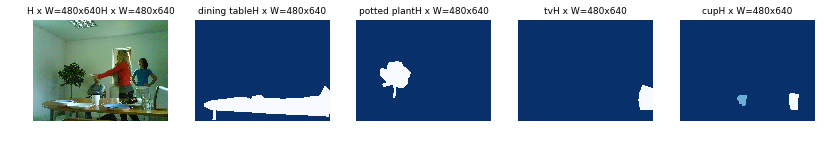

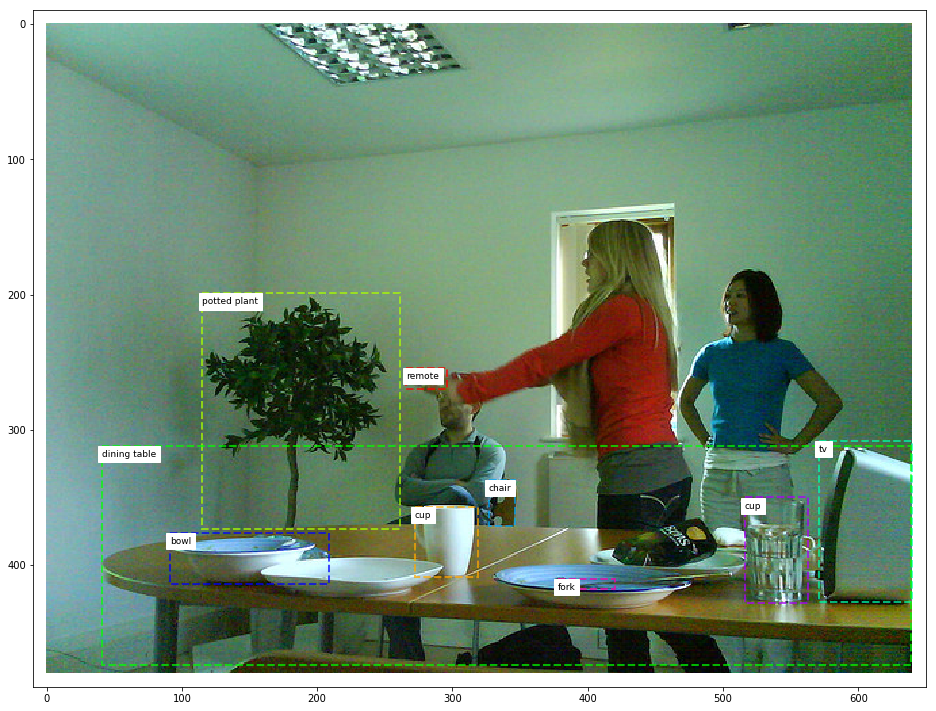

In [83]:
# IMAGE_LIST = [75040, 89243]
# IMAGE_LIST = [27711]
# IMAGE_LIST = [29731]   <--- Causes problems in generating the heatmap
# train_batch_x, train_batch_y  = data_gen_simulate(dataset_train, mrcnn_config, IMAGE_LIST )
train_batch_x, train_batch_y = next(train_generator)
IMAGE_LIST = train_batch_x[1][:,0]
display_training_batch(dataset_train, train_batch_x)


In [ ]:
print('IMAGE_LIST : ', IMAGE_LIST)
for image_id in IMAGE_LIST:
    print()
    print('IMAGE_ID : ', image_id)
    annotations = dataset_train.image_info[image_id]["annotations"]
#     print(annotations)
    for annotation in annotations:
        class_id = dataset_train.map_source_class_id( "coco.{}".format(annotation['category_id']))
        print("coco.id: {} --> class_id : {}  - {} ".format(annotation['category_id'],class_id, dataset_train.class_names[class_id]))

### other image displays

####  Display Training / Validation Training set information

In [ ]:
print("Train Dataset Image Count: {}".format(len(dataset_train.image_ids)))
print("Training Dataset Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
    
print("Validation Dataset Image Count: {}".format(len(dataset_val.image_ids)))
print("Validation Dataset Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))    

#### Display top masks for a random group of images

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 7)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### Display a random image with instances and mask

In [ ]:
# Load random image and mask.
# image_id = np.random.choice(dataset_train.image_ids)


image    = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])
# Display image and instances
visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)

## Run data through model

####  Display model input / output information

In [84]:
mrcnn_model.layer_info()



 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)
 index:  2    input name : input_rpn_match:0                          Type: int32             Shape: (?, ?, 1)
 index:  3    input name : input_rpn_bbox:0                           Type: float32           Shape: (?, ?, 4)
 index:  4    input name : input_gt_class_ids:0                       Type: int32             Shape: (?, ?)
 index:  5    input name : input_gt_boxes:0                           Type: float32           Shape: (?, ?, 4)


 Outputs:
 --------
 layer:  0    output name: cntxt_layer/pred_heatmap_norm:0            Type: float32           Shape: (1, 256, 256, 81)
 layer:  1    output name: cntxt_layer/pred_heatmap_scores:0          Type: float32           Shape: (1, 81, 200, 11)
 layer:  2    output name: cntxt_layer_gt/gt_heatmap

In [85]:
# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
# model_output = get_layer_output_1(mrcnn_model.keras_model, train_batch_x, [0,1,2,3,4,5,6,7,9,10,11], 1)
model_output = get_layer_output_1(mrcnn_model.keras_model, train_batch_x, [0,1,2,3,4,5,6], 1)


/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 89)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (1, 261888, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (1, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (1, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (1, 100, 4)

/* Outputs */
Output idx:  0    Layer:  0: (cntxt_layer/pred_heatmap_norm:0         ) 	  Output shape: (1, 256, 256, 81)
Output idx:  1    Layer:  1: (cntxt_layer/pred_heatmap_scores:0       ) 	  Output shape: (1, 81, 200, 11)
Output idx:  2    Layer:  2: (cntxt_layer_gt/gt_heatmap:0             ) 	  Output shape: (1, 256, 256, 81)
Output idx:  3    Layer:  3: (cntxt_layer_gt/gt_heatmap_scores:0      ) 	  Output shape: (1, 81, 200, 11)
Output idx:  4    Layer:  4: (proposal_targets/targ

### Load input and output tensors

#### Load output data

In [86]:
print(len(model_output))
model_pred_heatmap              = model_output[0]          # layer:  0   shape: (1, 256, 256, 81)
model_pred_heatmap_scores       = model_output[1]          # layer:  1   shape: (1, 81, 200, 11)
model_gt_heatmap                = model_output[2]          # layer:  2   shape: (1, 256, 256, 81)
model_gt_heatmap_scores         = model_output[3]          # layer:  3   shape: (1, 81, 200, 11)
model_target_class_ids          = model_output[4]          # layer:  4   shape: (1, 200)
model_mrcnn_class_logits        = model_output[5]          # layer:  5   shape: (1, 200, 81)
model_active_class_ids          = model_output[6]          # layer:  6   shape: (1, 81)
# model_output_rois               = model_output[0]          # layer:  4   shape: (1, 200, 4)
# model_target_class_ids          = model_output[1]          # layer:  5   shape: (1, 200)
# model_target_bbox_deltas        = model_output[2]          # layer:  6   shape: (1, 200, 4)
# model_roi_gt_boxes              = model_output[3]          # layer:  7   shape: (1, 200, 4)
# model_mrcnn_class_logits        = model_output[4]          # layer:  4   shape: (1, 200, 81)
# model_mrcnn_class               = model_output[5]          # layer:  5   shape: (1, 200, 81)
# model_mrcnn_bbox                = model_output[6]          # layer:  6   shape: (1, 200, 81, 4)
# model_pred_heatmap_norm         = model_output[0]          # layer:  0   shape: (2, 256, 256, 81)
# model_pred_heatmap_scores       = model_output[1]          # layer:  1   shape: (2, 81, 200, 11)
# model_gt_heatmap_norm           = model_output[2]          # layer:  2   shape: (2, 256, 256, 81)
# model_gt_heatmap_scores         = model_output[3]          # layer:  3   shape: (2, 81, 200, 11)
# model_pred_tensor               = model_output[4]          # layer:  4   shape: (2, 81, 200, 8)
# model_gt_tensor                 = model_output[5]          # layer:  5   shape: (2, 81, 200, 8)
for i in model_output:
    print( i.shape)

7
(1, 256, 256, 81)
(1, 81, 200, 11)
(1, 256, 256, 81)
(1, 81, 200, 11)
(1, 200)
(1, 200, 81)
(1, 81)


#### Load input data

In [ ]:
input_image          =  train_batch_x[0]
input_image_meta     =  train_batch_x[1]
# input_rpn_match      =  train_batch_x[2]
# input_rpn_bbox       =  train_batch_x[3]
input_gt_class_ids   =  train_batch_x[4]
input_gt_bboxes      =  train_batch_x[5]
print(' Input image shape is    :', input_image.shape)
print(' Input image_meta        :', type(input_image_meta), input_image_meta.shape)
print(' input_image_meta        :', input_image_meta[0,:10])
# print(' input_rpn_match         :', input_rpn_match.shape)
# print(' input_rpn_bbox          :', input_rpn_bbox.shape)
print(' input_gt_class_ids      :', input_gt_class_ids.shape)
print(' input_gt_bboxes         :', input_gt_bboxes.shape)
# h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
# input_gt_bboxes_norm = tf.identity(input_gt_bboxes / [h,w,h,w])
# print(' input_gt_bboxes_norm    :', input_gt_bboxes_norm.shape)

## Display output from model

####  `input_gt_class_ids`, `input_gt_bboxes`

In [ ]:
# print(roi_gt_boxes[0,:50] * [1024,1024,1024,1024])
print(input_gt_class_ids[0])
print(input_gt_bboxes[0,:10])
# for i in range(input_gt_class_ids.shape[1]):
#     if input_gt_class_ids[0,i] == 1:
#         print(input_gt_class_ids[0,i], '   ', input_gt_bboxes[0,i])

####  Display `output_rois`

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0
print(' output_rois')
print(model_output_rois.shape)
# print(output_rois[0,:40,:])
print(model_output_rois [0,:40,:]* [1024, 1024, 1024, 1024])

####  `max_mrcnn_class` , `argmax_mrcnn_class`

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
print(' mrcnn_class', model_mrcnn_class.shape)
print( model_mrcnn_class[0,:10,:20])
# 
max_mrcnn_class    = np.max(model_mrcnn_class, axis = (0,2))
argmax_mrcnn_class = np.argmax(model_mrcnn_class, axis = 2)

# print()
print('\n mrcnn_class Max Values   : ', max_mrcnn_class.shape)
print(max_mrcnn_class)

# print()
print(' mrcnn_class Argmax Values: ', argmax_mrcnn_class.shape)
print(argmax_mrcnn_class[0])

print(' target_class_ds    Values: ', model_target_class_ids.shape)
print(model_target_class_ids[0])

# for i in range(100):
#     print('Predicted: ', argmax_mrcnn_class[0,i],  '  Actual ', target_class_ids[0,i])
 

In [ ]:
print(' mrcnn_bbox')
print(model_mrcnn_bbox.shape)
print(model_mrcnn_bbox[0,0,:70])

#### Display  `target_class_ids()`, `target_bbox_deltas`, `roi_gt_boxes`

In [ ]:
print(' target_class_ids')
print(model_target_class_ids.shape)
print(model_target_class_ids[0])
# print(model_target_bbox_deltas.shape)
# print(model_target_bbox_deltas[0])
print(model_roi_gt_boxes.shape)
print(model_roi_gt_boxes[0])

####  apply `deltas` from predicted delta `mrcnn_bbox`  to  `output_rois` to obtain refined rois 

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img_idx = 0 
classes, deltas = utils.get_predicted_mrcnn_deltas(model_mrcnn_class, model_mrcnn_bbox, verbose=True)
print('output_rois',model_output_rois.shape, 'deltas ', deltas.shape)
cls = 48

for i in range(input_gt_class_ids.shape[1]):
    if input_gt_class_ids[0,i] == cls:
        print(input_gt_class_ids[0,i], '   ', input_gt_bboxes[0,i])

        
print()        
for i in range(model_output_rois.shape[1]):
    if classes[0,i] ==cls:
        print(' i ', i, 'class: ',classes[0,i])
#         print('   orig           : ', output_rois[0,i])
        d1 = deltas[0,i] * mrcnn_config.BBOX_STD_DEV
#         print('   delta          : ', deltas[0,i],'   delta * std dev: ', d1)
        d2 = utils.apply_box_delta(model_output_rois[0,i],d1)
#         print('   refined        : ', d2)
#         print()
        print('   orig           : ', model_output_rois[0,i] * [1024,1024,1024,1024])
        print('   refined        : ', d2 * [1024,1024,1024,1024]) 
        print('   roi_gt_bboxes  : ', model_roi_gt_boxes[0,i]* [1024,1024,1024,1024]) 
        print()
        print('   pred delta     : ', deltas[0,i] )
        print('   tgt delta      : ', model_target_bbox_deltas[0,i] )
        
        print()


####  Display roi_gt_boxes , and class_ids vs. output_bbox and prediceted class_ids

In [ ]:
print(ref_out_roi)

In [ ]:
ref_out_roi1 = ref_out_roi * [1024,1024,1024,1024]
print(ref_out_roi1)
window = np.array([0,0,1024,1024], dtype =float)
print(window.shape)
ref_out_roi2  = utils.clip_to_window_np( window, ref_out_roi1)
print(ref_out_roi2.shape)
for i in range(200):
    print(ref_out_roi1[i],' --- ', ref_out_roi2[i])

#### Display pred_refined_tensor and gt_tensor

In [ ]:
for cls in [1]:
    for box in range(20):
        print(pred_tensor[0,cls,box])
        print(gt_tensor[0,cls,box])
        print()

####  Display roi_gt_boxes along with corresponding refined/clipped output_rois

In [ ]:
img_id = 0
print(roi_gt_boxes[0].shape, target_class_ids[0].shape , np.expand_dims(target_class_ids[0],axis=-1).shape)
classes, deltas = utils.get_predicted_mrcnn_deltas(mrcnn_class, mrcnn_bbox, verbose=True)
deltas *= mrcnn_config.BBOX_STD_DEV
print('classes.shape: ',classes.shape, ' deltas.shape: ',deltas.shape)

ref_out_roi = utils.apply_box_deltas_np(output_rois[img_id],deltas[img_id])
#     ##   Clip boxes to image window    
# print(ref_out_roi.shape)
window = np.array([0,0,1024,1024], dtype =float)
clipped_out_roi  = utils.clip_to_window_np( window, ref_out_roi*[1024,1024,1024,1024])

for i in range(200):
#     ref_out_roi = utils.apply_box_delta_np(output_rois[0],d1[0])
#     if classes[img_id,i] == 1 or target_class_ids[img_id,i] == 1 :

    print('idx: ',200-i,' GT Cls: ', target_class_ids[img_id,i]  , ' -', roi_gt_boxes[img_id,i]*[1024,1024,1024,1024], 
                    ' PR Cls: ', classes[img_id,i],' - ', ref_out_roi[i]*[1024.0,1024.0,1024.0,1024.0] ,
                     'ClpdCls: ', clipped_out_roi[i]   ) #) *[1024,1024,1024,1024]

#### display gt_heatmap_scores and pred_heatmap_scores outputs

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])
img_id = 1
print(' GT Heatmap Scores')

print('gt_heatmap_scores: ', model_gt_heatmap_scores.dtype,  model_gt_heatmap_scores.shape)
print('pred_heatmap_scores: ', model_pred_heatmap_scores.dtype,  model_pred_heatmap_scores.shape)

# print(gt_heatmap_scores[img,1])
# for img_id in range(mrcnn_config.BATCH_SIZE):

for img_id in [0]:    # print(pred_refined_heatmap_scores[img_id,:4])
    pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist() 
    union_class_ids = np.union1d(pr_class_ids, gt_class_ids)
    print('-'*56)
    print('Image : {}  GT ClassIds: {}   PR ClassIds: {} '.format(img_id, gt_class_ids, pr_class_ids))
    print('Image : {}  Union ClassIds: {}'.format(img_id, union_class_ids))
    print('-'*56)
    for cls in union_class_ids:  
        print()
        for i in range(25):
#             print(' GT: img_id:',img_id, ' cls: ',cls, ' -',gt_tensor[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
#             print(' PR: img_id:',img_id, ' cls: ',cls, ' -',pred_tensor[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])

            print(' GT: img_id:',img_id, ' cls: ',cls, ' -',model_gt_heatmap_scores[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
            print(' PR: img_id:',img_id, ' cls: ',cls, ' -',model_pred_heatmap_scores[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])
            print()

####  Display `Pred_Tensor`, `Pred_heatmap`, `mrcnn_class`

In [ ]:
# np.set_printoptions(precision=4, threshold=None, linewidth=150, suppress=True)
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0

# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])

print('input_gt_class_ids')
print(input_gt_class_ids[0])

# print(' rpn_bbox')
# print(rpn_bbox.shape)
# print(rpn_bbox[0,:100,:])

# print(' rpn_roi_proposals')
# print(rpn_roi_proposals.shape)
# print(rpn_roi_proposals[0,:100,:])

print(' output_rois')
print(output_rois.shape)
# print(output_rois[0,:40,:])
print(output_rois [0,:40,:]* [1024, 1024, 1024, 1024])

print(' target_class_ids')
print(target_class_ids.shape)
print(target_class_ids[0,:40])
# print(output_rois [0,:40,:]* [1024, 1024, 1024, 1024])

# print(' Pred_tensor')
# print(pred_tensor.shape)
# print(pred_tensor[img,:,:10])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' mrcnn_class')
# print( mrcnn_class.shape)
# print( mrcnn_class[0,:,:])

# print(' mrcnn_bbox')
# print( mrcnn_bbox.shape)
# print( mrcnn_bbox)

# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:,:])

# print(' Pred Heatmap Scores')
# print(pred_heatmap_scores.dtype, pred_heatmap_scores.shape)
# print(pred_heatmap_scores[img,1])

# print(' FCN Scores')
# print(fcn_scores.dtype)
# for cls in range(4):
#     print(pred_heatmap_scores[img,cls,:10])
#     print(fcn_scores[img,cls,:10,2:])

  

####  Display `output_rois` for visual check - passed on to  `build_pred_tensor()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', output_rois.shape)
img = 0
for img in [0]:
    print('Image ', img , ' ------------')
    print(output_rois[img])

####  Display  - `pred_refined_tensor` which is passed on to  `build_heatmap()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
img_id = 0
# print('scatter shape is ', pred_scatt.get_shape())
print('model_pred_tensor shape is ', model_pred_tensor.shape)
print(input_image_meta[0,:10])
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  PR ClassIds: {} '.format(img_id, pr_class_ids))
for k in pr_class_ids:
    print('Image ', img , '/ Class ',k,' ------------')
    print(model_pred_tensor[img,k,:30])
    

####  Compare  `pred_heatmap_scores` vs. `pred_refined_heatmap_scores`

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
print('pred_refined_heatmap_scores',pred_refined_heatmap_scores.shape)
cls = 1
for i in range(input_gt_class_ids.shape[1]):
    if input_gt_class_ids[0,i] == cls:
        print(input_gt_class_ids[0,i], '   ', input_gt_bboxes[0,i])
print()        
for i in range(pred_heatmap_scores.shape[2]):
#     print(' ref_ten   : ', pred_refined_tensor[0,1,i])
    print(' hm_scr    : ', pred_heatmap_scores[0,1,i])
    print(' ref_hm_scr: ', pred_refined_heatmap_scores[0,1,i])
    print()    

##  `build_prediction()`

- pick the class with highest probability from mrcnn_class, and it's corresponding bounding box delta
- apply the deltas to the output_rois (output_roi)
- build tensor separating bounding boxes by class_id
- normalize scores per class
- sort based on sequence number 
 

###  Setup tensors to be passed to `build_predictions ()`    

In [ ]:
mrcnn_bbox  = tf.identity(model_mrcnn_bbox)
mrcnn_class = tf.identity(model_mrcnn_class)
norm_input_rois = tf.identity(model_output_rois)
config      = mrcnn_config
sess = KB.get_session()
print(' Keras session :', sess)
import mrcnn.utils as utils

###  `build_predictions()`

`pred_tensor[:,:,:,1:7]`  == `[116.9736  21.8213  36.2715  45.6026   0.    0.9139   ]`
 

In [ ]:
with sess.as_default():
# def build_predictions(norm_input_rois, mrcnn_class, mrcnn_bbox, config):
    '''
    Split output_rois by class id, and add class_id and class_score 
    
    output:
    -------
    
    pred_tensor:        [ Bsz, Num_Classes, Num_Rois, 7: 
                            {y1, x1, y2, x2, class_id, class_score, normalized class score}]
                        
                        y1,x1, y2,x2 are in image dimension format
    '''
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES
    h, w            = config.IMAGE_SHAPE[:2]
    # num_rois        = config.TRAIN_ROIS_PER_IMAGE
    num_rois        = KB.int_shape(norm_input_rois)[1]
    scale           = tf.constant([h,w,h,w], dtype = tf.float32)
    # dup_scale       = tf.reshape(tf.tile(scale, [num_rois]),[num_rois,-1])
    dup_scale       = scale * tf.ones([batch_size, num_rois, 1], dtype = 'float32')
    det_per_class   = config.DETECTION_PER_CLASS
    
    print()
    print('  > build_predictions()')
    print('    num_rois               : ', num_rois )
    print('    norm_input_rois.shape  : ', type(norm_input_rois), KB.int_shape(norm_input_rois))
    print('    scale.shape            : ', type(scale), KB.int_shape(scale), scale.get_shape())
    print('    dup_scale.shape        : ', type(dup_scale), KB.int_shape(dup_scale), dup_scale.get_shape())
    print()
    print('    mrcnn_class shape      : ', KB.int_shape(mrcnn_class))
    print('    mrcnn_bbox.shape       : ', KB.int_shape(mrcnn_bbox), mrcnn_bbox.shape )
    print('    config image shape     : ', config.IMAGE_SHAPE, 'h:',h,'w:',w)

    #---------------------------------------------------------------------------
    # Build a meshgrid for image id and bbox to use in gathering of bbox delta information 
    #---------------------------------------------------------------------------
    batch_grid, bbox_grid = tf.meshgrid( tf.range(batch_size, dtype=tf.int32),
                                         tf.range(num_rois, dtype=tf.int32), indexing = 'ij' )

    #------------------------------------------------------------------------------------
    # use the argmaxof each row to determine the dominating (predicted) class
    #------------------------------------------------------------------------------------
    pred_classes     = tf.argmax( mrcnn_class,axis=-1,output_type = tf.int32)
    pred_classes_exp = tf.to_float(tf.expand_dims(pred_classes ,axis=-1))    
    #     print('    pred_classes : ', pred_classes.shape)
    #     print(pred_classes.eval())
    #     print('    pred_scores  : ', pred_scores.shape ,'\n', pred_scores.eval())
    #     print('    pred_classes_exp : ', pred_classes_exp.shape)
    
    gather_ind   = tf.stack([batch_grid , bbox_grid, pred_classes],axis = -1)
    pred_scores  = tf.gather_nd(mrcnn_class, gather_ind)
    pred_deltas  = tf.gather_nd(mrcnn_bbox , gather_ind)

    ##------------------------------------------------------------------------------------
    ## apply delta refinements to the  rois,  based on deltas provided by the mrcnn head 
    ##------------------------------------------------------------------------------------
    pred_deltas  = tf.multiply(pred_deltas, config.BBOX_STD_DEV, name = 'pred_deltas')
    input_rois   = tf.multiply(norm_input_rois , dup_scale )

    ## compute "refined rois"  utils.apply_box_deltas_tf(input_rois, pred_deltas)
    refined_rois   = utils.apply_box_deltas_tf(input_rois, pred_deltas)

    ##   Clip boxes to image window    
    window = tf.constant([[0,0,h,w]], dtype = tf.float32)
    refined_rois  = utils.clip_to_window_tf( window, refined_rois)
    
    print('    refined rois clipped   : ', refined_rois.shape)
    print('    input_rois.shape       : ', KB.int_shape(input_rois), input_rois.get_shape())
    print('    refined_rois.shape     : ', KB.int_shape(refined_rois), refined_rois.get_shape())
    # print('    mrcnn_class : ', mrcnn_class.shape, mrcnn_class)
    # print('    gather_ind  : ', gather_ind.shape, gather_ind)
    # print('    pred_scores : ', pred_scores.shape )
    # print('    pred_deltas : ', pred_deltas.shape )   
    # print('    input_rois : ', input_rois.shape, input_rois)
    # print('    refined rois: ', refined_rois.shape, refined_rois)
        
    ##------------------------------------------------------------------------------------
    ##  Build Pred_Scatter: tensor of bounding boxes by Image / Class
    ##------------------------------------------------------------------------------------
    ## sequence id is used to preserve the order of rois as passed to this routine
    ##  This may be important in the post matching process but for now it's not being used.
    ## 22-09-18 : We need to use this sequence as the sort process based on score will cause
    ##            mismatch between the bboxes from output_rois and roi_gt_bboxes
    ##------------------------------------------------------------------------------------
    sequence = tf.ones_like(pred_classes, dtype = tf.int32) * (bbox_grid[...,::-1] + 1) 
    sequence = tf.to_float(tf.expand_dims(sequence, axis = -1))   
    print('    shape of sequence      : ', sequence.shape)
    pred_array  = tf.concat([ refined_rois, pred_classes_exp , tf.expand_dims(pred_scores, axis = -1), sequence],
                            axis=-1, name = 'pred_array')
     
    scatter_ind = tf.stack([batch_grid , pred_classes, bbox_grid],axis = -1)
    pred_scatt  = tf.scatter_nd(scatter_ind, pred_array, [batch_size, num_classes, num_rois, pred_array.shape[-1]])
    print('    pred_array             : ', pred_array.shape)  
    print('    scatter_ind            : ', type(scatter_ind), 'shape', scatter_ind.shape)
    print('    pred_scatter           : ', pred_scatt.get_shape())
    
    ##--------------------------------------------------------------------------------------------
    ##  Apply a per class score normalization using the score column (COLUMN 5)
    ##  
    ##--------------------------------------------------------------------------------------------
    normalizer   = tf.reduce_max(pred_scatt[...,5], axis = -1, keepdims=True)
    normalizer   = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    norm_score   = tf.expand_dims(pred_scatt[...,5]/normalizer, axis = -1)
    pred_scatt   = tf.concat([pred_scatt, norm_score],axis = -1)   
    print('    - Add normalized score --\n')
    print('    normalizer             : ', normalizer.shape)  
    print('    norm_score             : ', norm_score.shape)
    print('    pred_scatter           : ', pred_scatt.get_shape())
    
    ##------------------------------------------------------------------------------------
    ## Sort pred_scatt to push valid bounding boxes to top for each class dimension
    ##
    ## 22-09-2018: sort is now based on sequence which was added as last column
    ##             (previously sort was on bbox scores)
    ##------------------------------------------------------------------------------------
    _, sort_inds = tf.nn.top_k(pred_scatt[...,6], k=pred_scatt.shape[2])
    
    # build indexes to gather rows from pred_scatter based on sort order    
    class_grid, batch_grid, roi_grid = tf.meshgrid(tf.range(num_classes),tf.range(batch_size), tf.range(num_rois))
    roi_grid_exp = tf.to_float(tf.expand_dims(roi_grid, axis = -1))
    
    gather_inds  = tf.stack([batch_grid , class_grid, sort_inds],axis = -1)
    pred_tensor  = tf.gather_nd(pred_scatt, gather_inds[...,:det_per_class,:], name = 'pred_tensor')    

    print('    sort_inds              : ', type(sort_inds)   , ' shape ', sort_inds.shape)
    print('    class_grid             : ', type(class_grid)  , ' shape ', class_grid.get_shape())
    print('    batch_grid             : ', type(batch_grid)  , ' shape ', batch_grid.get_shape())
    print('    roi_grid shape         : ', type(roi_grid)    , ' shape ', roi_grid.get_shape()) 
    print('    roi_grid_exp           : ', type(roi_grid_exp), ' shape ', roi_grid_exp.get_shape())
    print('    gather_inds            : ', type(gather_inds) , ' shape ', gather_inds.get_shape())
    print('    pred_tensor            : ', pred_tensor.get_shape())

#     return  pred_tensor


In [ ]:
### Reshape pred_scatt??  No, doesn't work well as the reshape will convert into [batch_sz, #classes x # bboxes, 8]
# btch_sz, cls_sz, bbox_sz, col_sz = pred_scatt.shape
# print(btch_sz, cls_sz, bbox_sz, col_sz )
# reshape = tf.reshape(pred_scatt, [btch_sz, -1, col_sz])
# print(reshape.shape)

### This works well, converts pred_scatter back to pred_array (with added normzalized score column)
# 
# reshape = tf.gather_nd(pred_scatt, scatter_ind )


###  Display `pred_tensor`  from model code and code above, `pred_heatmap_scores`  

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor            : ', pred_tensor.get_shape() )
# print('pred tensor from model : ', model_pred_tensor.shape)
with sess.as_default():
    r_pred_tensor = pred_tensor.eval()
    
    
for img in range(2):
    class_ids = np.unique(r_pred_tensor[img,:,:,4]).astype(int).tolist()    
    print('Classids: ', class_ids)
    for i in class_ids:
        print('Image ', img , '/ Class ',i,' ------------')
        for j in range(25):
            print(r_pred_tensor[img,i,j])
#             print(model_pred_tensor[img,i,j])
#             print(model_pred_heatmap_scores[img,i,j])
#             print(pred_heatmap_scores[img,i,j])
            print()


In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
with sess.as_default():
    print(scatter_ind.shape)
    print(pred_scatt.shape)
    print(pred_array.shape)
#     r_clipped_rois = clipped_rois.eval()
    r_pred_array = pred_array.eval()
for i in range(200):
#     print()
#     print('input_ro:  ', r0[0,i]) 
#     print('original (clipped) :  ', r_clipped_rois[0,i])
    print('pred_array         :  ', r_pred_array[0,i])

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)

# with sess.as_default():
#     print(pred_scores.eval())
#     print(pred_classes.eval())
#     print(scatter_ind.eval()[0])
#     print(norm_score.eval()[0,9])
#     print(pred_array.eval()[0,:200])
#     print(scatter_ind.shape)
#     print(pred_scatt.shape)
#     print(pred_array.shape)
#     r_clipped_rois = clipped_rois.eval()
#     r_pred_array   = pred_array.eval()
#     print(pred_scatt.eval()[0,1,0:200])
#     print(normalizer.eval()[0,9])


### Some tests on the results

####  Test that refined_rois is correctly working in `clip_to_window_tf` 

In [ ]:
with sess.as_default():
    test_np = refined_rois.eval()
    test_tf = refined_rois_clipped.eval()
    window_np = np.array([0,0,128,128])
 
    print(window_np.shape)
    for i in range(5):
#         print('Before', i)
#         print(test_np[i])
        test_np[i] = clip_to_window(window_np, test_np[i])
#         print('After', i)
#         print(test_np[i])
#         print('   tensor flow')
#         print(test_tf[i])
        
    for i in range(5):
      all_equal = np.all(test_np == refined_rois_clipped.eval())
      print('i: ', i, '--- EQUAL : ', all_equal)


####  Test that pred_classes and pred_deltas have been properly selected when using tf.gather_nd ()

In [ ]:
with sess.as_default():
    tmp0 = pred_classes.eval()
    tmp1 = mrcnn_bbox.eval()
    tmp2 = pred_deltas.eval()
    tmp4 = mrcnn_class.eval()
    tmp3 = pred_scores2.eval()
    tmp5 = pred_scores.eval()
    

for i in range(5):
    for j in range(32):
        print('i: ', i, ' j :', j,'--- class: ',tmp0[i,j],'---------------')
    #     print(tmp0[i,j])
        print(tmp1[i,j])
        print(' ===> ', tmp2[i,j])
        print(' mrcnn_score: ', tmp4[i,j,tmp0[i,j]], ' pred_score:', tmp5[i,j,0], 'pred_score2: ', tmp3[i,j])


####  Verify refined_rois generated by TF and NP are equal when using `apply_box_deltas_tf( )`

In [ ]:
from mrcnn.utils import apply_box_deltas, apply_box_deltas_tf
with sess.as_default():
    refined_rois_tf = apply_box_deltas_3d(output_rois, pred_deltas).eval()
    print(' refined rois_tf: ', refined_rois_tf.shape, refined_rois_tf.dtype)
    tmp = []
    bxs = output_rois.eval()
    dlt = pred_deltas.eval()
    for i in range(5):
        tmp.append(apply_box_deltas(bxs[i], dlt[i]))
    refined_rois_np = np.asarray(tmp)
    print(' refined rois_np: ', refined_rois_np.shape,refined_rois_np.dtype)
    print(' refined rois_np == refined rois_tf ?? :', np.all(refined_rois_tf[0,1] == refined_rois_np[0,1]))

#     for i in range(5):
#         for j in range(32):
#             all_eq = np.all(refined_rois_tf[0,1] == refined_rois_np[0,1])
#             if ~all_eq:
#                 print(' Not equal : ',i,'/',j)
#                 print(refined_rois_tf[i,j])
#                 print(refined_rois_np[i,j])
#             else:
#                 print(' equal : ',i,'/',j)
print(refined_rois_tf[0])
print(refined_rois_np[0])


## `build_heatmap()`

### Prepare values to pass to build_heatmap

In [ ]:
# def build_heatmap(in_tensor, config, names = None):
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
print(model_pred_tensor.shape)
in_tensor = tf.identity(model_pred_tensor)
# in_tensor   = pred_tensor
# in_array    = pred_array 
sess = KB.get_session()
config = mrcnn_model.config
names = ['test']

###  `build_heatmap()` - part 1

In [ ]:
##-----------------------------------------------------------------------------------------------------------
##  build_heatmap : Build gaussian heatmaps using pred_tensor
##  
##  v2: in this version, "build_hm_score" function which calculates scores is applied to "prob_grid_norm_scaled", 
##      the normalized gaussian distributions that have been multiplied by the normalized score coming from i
##      in_tensor (i.e., steps(1,2) applied)
##------------------------------------------------------------------------------------------------------------
# def build_heatmap(in_tensor, config, names = None):
  
with sess.as_default():    
    num_detections  = config.DETECTION_MAX_INSTANCES
    img_h, img_w    = config.IMAGE_SHAPE[:2]
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES  
    heatmap_scale   = config.HEATMAP_SCALE_FACTOR
    grid_h, grid_w  = config.IMAGE_SHAPE[:2] // heatmap_scale    
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES
    #   strt_cls        = 0 if rois_per_image == 32 else 1
    # rois_per_image  = config.DETECTION_PER_CLASS
    rois_per_image  = (in_tensor.shape)[2]  

    print('\n ')
    print('  > build_heatmap() for ', names )
    print('    in_tensor shape        : ', in_tensor.shape)       
    print('    num bboxes per class   : ', rois_per_image )
    print('    heatmap scale        : ', heatmap_scale, 'Dimensions:  w:', grid_w,' h:', grid_h)
    
    ##-----------------------------------------------------------------------------    
    ## Stack non_zero bboxes from in_tensor into pt2_dense 
    ##-----------------------------------------------------------------------------
    # pt2_ind shape is [?, 3]. 
    #    pt2_ind[0] corresponds to image_index 
    #    pt2_ind[1] corresponds to class_index 
    #    pt2_ind[2] corresponds to roi row_index 
    # pt2_dense shape is [?, 7]
    #    pt2_dense[0:3]  roi coordinates 
    #    pt2_dense[4]    is class id 
    #    pt2_dense[5]    is score from mrcnn    
    #    pt2_dense[6]    is bbox sequence id    
    #    pt2_dense[7]    is normalized score (per class)    
    #-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:4]), axis=-1)
    pt2_ind = tf.where(pt2_sum > 0)
    pt2_dense = tf.gather_nd( in_tensor, pt2_ind)

    print('    pt2_sum shape  : ', pt2_sum.shape)
    print('    pt2_ind shape  : ', pt2_ind.shape)
    print('    pt2_dense shape: ', pt2_dense.get_shape())

    ##-----------------------------------------------------------------------------
    ## Build mesh-grid to hold pixel coordinates  
    ##-----------------------------------------------------------------------------
    X = tf.range(grid_w, dtype=tf.int32)
    Y = tf.range(grid_h, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)

    # duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    ones = tf.ones([tf.shape(pt2_dense)[0] , 1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

    # # stack the X and Y grids 
    pos_grid = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
    print('    pos_grid before transpse : ', pos_grid.get_shape())
    pos_grid = tf.transpose(pos_grid,[1,2,0,3])
    print('    pos_grid after transpose : ', pos_grid.get_shape())    

    ##-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    ##-----------------------------------------------------------------------------
    pt2_dense_scaled = pt2_dense[:,:4]/heatmap_scale
    width  = pt2_dense_scaled[:,3] - pt2_dense_scaled[:,1]      # x2 - x1
    height = pt2_dense_scaled[:,2] - pt2_dense_scaled[:,0]
    cx     = pt2_dense_scaled[:,1] + ( width  / 2.0)
    cy     = pt2_dense_scaled[:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)

    ##-----------------------------------------------------------------------------
    ##  Compute Normal Distribution for bounding boxes
    ##-----------------------------------------------------------------------------    
    tfd = tf.contrib.distributions
    mvn = tfd.MultivariateNormalDiag(loc = means,  scale_diag = covar)
    prob_grid = mvn.prob(pos_grid)
    print('    >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.shape)
    print('     Prob_grid shape from mvn.probe: ',prob_grid.shape)
    prob_grid = tf.transpose(prob_grid,[2,0,1])
    print('     Prob_grid shape after tanspose: ',prob_grid.shape)    
    print('    << output probabilities shape  : ' , prob_grid.shape)

    #--------------------------------------------------------------------------------
    # Kill distributions of NaN boxes (resulting from bboxes with height/width of zero
    # which cause singular sigma cov matrices
    #--------------------------------------------------------------------------------
    # prob_grid = tf.where(tf.is_nan(prob_grid),  tf.zeros_like(prob_grid), prob_grid)

    ##---------------------------------------------------------------------------------------------
    ## (NEW STEP) Clip heatmap to region surrounding Cy,Cx and Covar X, Y 
    ##            Similar ro what is being done for gt_heatmap in CHMLayerTarget 
    ## added 16-10-2018 to test functionality 
    ##---------------------------------------------------------------------------------------------    
    prob_grid_clipped = tf.map_fn(clip_heatmap, [prob_grid, cy,cx, covar], 
                                 dtype = tf.float32, swap_memory = True)     
    ##---------------------------------------------------------------------------------------------
    ## (1) apply normalization per bbox heatmap instance
    ##---------------------------------------------------------------------------------------------
    print('\n    normalization ------------------------------------------------------')   
    normalizer = tf.reduce_max(prob_grid_clipped, axis=[-2,-1], keepdims = True)
    normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    print('    normalizer     : ', normalizer.shape) 
    prob_grid_norm = prob_grid_clipped / normalizer

    ##---------------------------------------------------------------------------------------------
    ## (2) multiply normalized heatmap by normalized score in in_tensor/ (pt2_dense column 7)
    ##     broadcasting : https://stackoverflow.com/questions/49705831/automatic-broadcasting-in-tensorflow
    ##---------------------------------------------------------------------------------------------    
    prob_grid_norm_scaled = tf.transpose(tf.transpose(prob_grid_norm_scaled) * pt2_dense[:,7])
    print('    prob_grid_norm_scaled : ', prob_grid_norm_scaled.shape)

     

####  Tests

In [ ]:
with sess.as_default():
    # print(prob_grid_norm.shape)
    # r_normalizer = normalizer.eval()    
#     r_prob_grid = prob_grid.eval()
#     r_prob_grid_norm = prob_grid_norm.eval()
#     r_prob_grid_norm_scaled = prob_grid_norm_scaled.eval()
    r_maxes2 = maxes2.eval()
    r_score  = pt2_dense[:,7].eval()
#     r_pt2_dense = pt2_dense.eval()
#     r_cx, r_cy  = cx.eval(), cy.eval()

In [ ]:
# print(r_normalizer.shape)
# print(r_prob_grid.shape, r_prob_grid_norm.shape)
# print(r_maxes0.shape)
# print(r_maxes1.shape)
print(r_maxes2.shape)
print(r_score.shape)
# print(r_pt2_dense[:50])
for i in range(20):
    print('   ', r_score[i], '   ', r_maxes2[i],'  ') # , r_pt2_dense[i],r_cx[i], r_cy[i])

In [ ]:
for y in [111,112,113]:
    print(r_prob_grid[0,y,95:115])
    print(r_prob_grid_norm[0,y,95:115])
    print(r_prob_grid_norm_scaled[0,y,95:115])
    print()

In [ ]:
from mrcnn.visualize import plot_2d_gaussian, plot_3d_gaussian
box = 23
plot_3d_gaussian(r_prob_grid[box], zlim = 0.1)
plot_3d_gaussian(r_prob_grid_norm[box])
plot_3d_gaussian(r_prob_grid_norm_scaled[box])

###   `build_heatmap()` - part 2 - Calculate heatmap sum 

In [ ]:
with sess.as_default():  
    ##-------------------------------------------------------------------------------------
    ## (3) scatter out the probability distributions based on class 
    ##-------------------------------------------------------------------------------------
    print('\n    Scatter out the probability distributions based on class --------------') 
#     gauss_scatt   = tf.scatter_nd(pt2_ind, prob_grid_norm_scaled, 
#                                   [batch_size, num_classes, rois_per_image, grid_w, grid_h], 
#                                   name = 'gauss_scatter')
    gauss_scatt   = tf.scatter_nd(pt2_ind, prob_grid_norm_scaled, 
                                  [batch_size, num_classes, rois_per_image, grid_w, grid_h], 
                                  name = 'gauss_scatter')    
    print('    pt2_ind shape   : ', pt2_ind.shape)  
    print('    prob_grid shape : ', prob_grid.shape)  
    print('    gauss_scatt     : ', gauss_scatt.shape)   # batch_sz , num_classes, num_rois, image_h, image_w

    ##-------------------------------------------------------------------------------------
    ## (4) SUM : Reduce and sum up gauss_scattered by class  
    ##-------------------------------------------------------------------------------------
    print('\n    Reduce sum based on class ---------------------------------------------')         
    gauss_heatmap = tf.reduce_sum(gauss_scatt, axis=2, name='pred_heatmap2')
    #--------------------------------------------------------------------------------------
    # force small sums to zero - for now (09-11-18) commented out but could reintroduce based on test results
    # gauss_heatmap = tf.where(gauss_heatmap < 1e-12, gauss_heatmap, tf.zeros_like(gauss_heatmap), name='Where1')
    #--------------------------------------------------------------------------------------
    print('    gaussian_heatmap : ', gauss_heatmap.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_heatmap) )      
    
    ##---------------------------------------------------------------------------------------------
    ## (5) heatmap normalization
    ##     normalizer is set to one when the max of class is zero     
    ##     this prevents elements of gauss_heatmap_norm computing to nan
    ##---------------------------------------------------------------------------------------------
    print('\n    normalization ------------------------------------------------------')   
    normalizer = tf.reduce_max(gauss_heatmap, axis=[-2,-1], keepdims = True)
    normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    gauss_heatmap_norm = gauss_heatmap / normalizer
    print('    normalizer shape : ', normalizer.shape)   
    print('    gauss norm       : ', gauss_heatmap_norm.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_norm) )
    
      
    ##--------------------------------------------------------------------------------------------
    ## //create heatmap Append `in_tensor` and `scores_from_sum` to form `bbox_scores`
    ##--------------------------------------------------------------------------------------------
    # gauss_heatmap  = tf.transpose(gauss_heatmap,[0,2,3,1], name = names[0])
    # print('    gauss_heatmap : ', gauss_heatmap.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap))
    
    gauss_heatmap_norm = tf.transpose(gauss_heatmap_norm,[0,2,3,1], name = names[0]+'_norm')
    print('    gauss_heatmap_norm : ', gauss_heatmap_norm.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_norm) )
    

    ##--------------------------------------------------------------------------------------------
    ##  Generate scores using prob_grid and pt2_dense - NEW METHOD
    ##  added 09-21-2018
    ##--------------------------------------------------------------------------------------------
    scores_from_sum2 = tf.map_fn(build_hm_score, [prob_grid, pt2_dense_scaled, pt2_dense[:,7]], 
                                 dtype = tf.float32, swap_memory = True)
    scores_scattered = tf.scatter_nd(pt2_ind, scores_from_sum2, 
                                     [batch_size, num_classes, rois_per_image, 3], name = 'scores_scattered')
    gauss_scores = tf.concat([in_tensor, scores_scattered], axis = -1,name = names[0]+'_scores')
    print('    scores_scattered shape : ', scores_scattered.shape) 
    print('    gauss_scores           : ', gauss_scores.shape, ' Name:   ', gauss_scores.name)
    print('    gauss_scores  (FINAL)  : ', gauss_scores.shape, ' Keras tensor ', KB.is_keras_tensor(gauss_scores) )         
    print('    complete')
 

###  Alternative method: use `scatter_nd_add` to build guassian sum
requires definition of tf.variable

In [ ]:
with sess.as_default():
#   kvar = KB.variable(value = KB.zeros([batch_size, num_classes, grid_w, grid_h], dtype = 'float32'))
#   kvar = tf.scatter_nd_add(kvar, pt2_ind[:,:2],prob_grid)

#   kvar_norm  = KB.variable(value = KB.zeros([batch_size, num_classes, grid_w, grid_h], dtype = 'float32'))
#   kvar_norm = tf.scatter_nd_add(kvar_norm, pt2_ind[:,:2],prob_grid)

    kvar_norm_scaled = KB.variable(value = KB.zeros([batch_size, num_classes, grid_w, grid_h], dtype = 'float32'))
    kvar_norm_scaled = KB.zeros([batch_size, num_classes, grid_w, grid_h])
    kvar_norm_scaled = tf.scatter_nd_add(kvar_norm_scaled, pt2_ind[:,:2],prob_grid_norm_scaled)

    ##---------------------------------------------------------------------------------------------
    ## heatmap normalization
    ## normalizer is set to one when the max of class is zero     
    ## this prevents elements of gauss_heatmap_norm computing to nan
    ##---------------------------------------------------------------------------------------------
    print('\n    normalization ------------------------------------------------------')   
    normalizer = tf.reduce_max(kvar_norm_scaled, axis=[-2,-1], keepdims = True)
    normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    gaussian_heatmap_norm = kvar_norm_scaled / normalizer
    # gauss_heatmap_norm    = gauss_heatmap / tf.reduce_max(gauss_heatmap, axis=[-2,-1], keepdims = True)
    # gauss_heatmap_norm    = tf.where(tf.is_nan(gauss_heatmap_norm),  tf.zeros_like(gauss_heatmap_norm), gauss_heatmap_norm, name = 'Where2')
    print('    gauss norm            : ', gaussian_heatmap_norm.shape  )        

#### Tests

In [ ]:
with sess.as_default():
#     r_ghm  = gauss_heatmap.eval()
    r_kvar = KB.eval(kvar)
    r_kvar_norm = KB.eval(kvar_norm)
    r_kvar_norm_scaled = KB.eval(kvar_norm_scaled)
    r_kvar_final = kvar_final.eval()
#     r_kvar = kvar.eval()
#     r_kvar_norm = kvar_norm.eval()
#     r_kvar_norm_scaled = kvar_norm_scaled.eval()
#     r_kvar_final = kvar_final.eval()

In [ ]:
print(r_kvar.shape, r_kvar_norm.shape, r_kvar_norm_scaled.shape, r_kvar_final.shape)

In [ ]:
# np.set_printoptions(precision=4, threshold=30000, linewidth=260, suppress=True)
# print(r_kvar.shape, r_ghm.shape)
# print(kvar, gauss_heatmap)
# for  i in [9]:  #range(81):
#     for j in range(256):
#         print(' Col: ', j, ': ',np.all(r_kvar[0,i,j] == r_ghm[0,i,j]))


In [ ]:
from mrcnn.visualize import plot_2d_gaussian, plot_3d_gaussian
cls = 1
plot_3d_gaussian(r_ghm[0,cls])
plot_3d_gaussian(r_kvar[0,cls])
plot_3d_gaussian(r_kvar_norm[0,cls])
plot_3d_gaussian(r_kvar_final[0,cls])

# for i in range(81):
#     print(np.max(r_kvar[0,i]), np.max(r_ghm[0,i]), np.sum(r_kvar[0,i]),np.sum(r_ghm[0,i]))
# plot_3d_gaussian(r_prob_grid_norm_scaled[box])

In [ ]:
# np.set_printoptions(linewidth=150, precision=6)
# # print('scatter shape is ', pred_scatt.get_shape())
# print('pt2_dense shape is ', pt2_dense.get_shape() )
# with sess.as_default():
#     r_pt2_ind   = pt2_ind.eval()
#     r_pt2_dense = pt2_dense.eval()
#     X1,Y1 = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(num_detections, dtype=tf.int32), indexing = 'ij')
#     r_X1 = X1.eval()
#     r_Y1 = Y1.eval()
# print(r_X1.shape , Y1.shape)
# print(r_X1)
# print(r_Y1)
# print(r_pt2_ind.shape)
# where_to_go = np.stack([r_pt2_ind[:,0],r_pt2_dense[:,4], r_pt2_dense[:,6]],axis =-1)
# print(where_to_go.shape)
# print(where_to_go)

# class_ids = np.unique(r_pt2_dense[:,4]).astype(int).tolist()    
# print('Classids: ', class_ids)

# for box in range(r_pt2_ind.shape[0]):
#     print(r_pt2_ind[box],'      ', r_pt2_dense[box,:])

In [ ]:
#     gauss_sum = tf.zeros([batch_size, num_classes, rois_per_image, img_w//scale, img_h//scale])
#     print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )      

#     counter = 0
#     limit   = batch_size * rois_per_image
#     c = lambda i, j, k,l: tf.less_equal(i, pt2_ind.get_shape()[0])
#     b = lambda i, j, k,l: tf.add(j[k[i]], l[i])
#     loop_vars = [counter, gauss_sum, pt2_ind, prob_grid]
#     tf.while_loop(c, b, loop_vars)


#     print('pt2_dense shape',pt2_dense.shape)
#     for i in range(pt2_dense.shape[0]):
#         print('i', i, 'pt2_ind[i]',pt2_ind[i].shape)
#         gauss_sum[pt2_ind[i,:]] += prob_grid[i]

In [ ]:
with sess.as_default():
#     init_sum.initializer()
    r_ghm_norm  = gauss_heatmap_norm.eval()

In [ ]:
from mrcnn.visualize import plot_2d_gaussian, plot_3d_gaussian
box = 23
plot_3d_gaussian(r_ghm_norm[0,1])
plot_3d_gaussian(r_ghm[0,1])
# for i in range(81):
#     print(np.max(r_kvar[0,i]), np.max(r_ghm[0,i]), np.sum(r_kvar[0,i]),np.sum(r_ghm[0,i]))
# plot_3d_gaussian(r_prob_grid_norm_scaled[box])

###  `build_hm_score()`

In [ ]:
def build_hm_score(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
        weighted_sum :      gaussian_sum * bbox_score
    '''
    heatmap_tensor, input_bbox, input_norm_score = input_list
    
    with tf.variable_scope('mask_routine'):
        y_extent     = tf.range(input_bbox[0], input_bbox[2])
        x_extent     = tf.range(input_bbox[1], input_bbox[3])
        Y,X          = tf.meshgrid(y_extent, x_extent)
        bbox_mask    = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        # mask_sum    =  tf.reduce_sum(mask)
        heatmap_tensor = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        bbox_area    = tf.to_float((input_bbox[2]-input_bbox[0]) * (input_bbox[3]-input_bbox[1]))
        gaussian_sum = tf.reduce_sum(heatmap_tensor)

        # Multiply gaussian_sum by score to obtain weighted sum    
        # weighted_sum = gaussian_sum * input_row[5]

        # Replaced lines above with following lines 21-09-2018
        # Multiply gaussian_sum by normalized score to obtain weighted_norm_sum 
        weighted_norm_sum = gaussian_sum * input_norm_score    # input_list[7]

    return tf.stack([gaussian_sum, bbox_area, weighted_norm_sum], axis = -1)

def clip_heatmap(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        cy,cx, covar   :   
        
    Returns
    -----------
        Clipped heatmap tensor 
    '''
    heatmap_tensor, cy, cx, covar = input_list

    with tf.variable_scope('mask_routine'):
        start_y      = tf.maximum(cy-covar[1],0)
        end_y        = tf.minimum(cy+covar[1], KB.int_shape(heatmap_tensor)[0])
        start_x      = tf.maximum(cx-covar[0],0)
        end_x        = tf.minimum(cx+covar[0], KB.int_shape(heatmap_tensor)[1])
        y_extent     = tf.range(start_y, end_y)
        x_extent     = tf.range(start_x, end_x)
        Y,X          = tf.meshgrid(y_extent, x_extent)
        mask_indices = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(mask_indices,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        # mask_sum    =  tf.reduce_sum(mask)
        heatmap_tensor = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')

    return  heatmap_tensor
                  

### Evaluate results from `build_heatmap()`

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
with sess.as_default():
#     sess.run( tf.global_variables_initializer())
#     gauss_scatt         = gauss_scatt.eval()
#     pred_heatmap        = gauss_sum.eval()
#     r_normalizer        = normalizer.eval()
    pred_heatmap_norm   = gauss_heatmap_norm.eval()
    pred_heatmap_scores = gauss_scores.eval()
#     prob_grid           = prob_grid.eval()
#     r_scores_from_sum2 = scores_from_sum2.eval()

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0
# print(gauss_sum.shape)
# print(gauss_scatt.shape)
# print(pred_heatmap.shape)
# print(r_normalizer.shape)
print(pred_heatmap_norm.shape)
print(model_pred_heatmap_norm.shape)
print(model_gt_heatmap_norm.shape)
# print(r_scores_from_sum2.shape)
print(pred_heatmap_scores.shape)
print(model_pred_heatmap_scores.shape)
print(model_gt_heatmap_scores.shape)
# print(pred_heatmap_scores[0,1])

#### compare results of `pred_heatmap_scores` from code above and program file

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
 
print('pred_heatmap_scores shape is       ', pred_heatmap_scores.shape )
print('pred_heatmap_scores from model is :', model_pred_heatmap_scores.shape)
# with sess.as_default():
#     r_pred_tensor = pred_tensor.eval()
for img in [0]:
    class_ids = np.unique(pred_heatmap_scores[img,:,:,4]).astype(int).tolist()    
    print('Classids: ', class_ids)
    for i in class_ids:
        print('Image ', img , '/ Class ',i)
        
        for j in range(200):
            print(model_gt_heatmap_scores[img,i,j])
            print(pred_heatmap_scores[img,i,j])
            print(model_pred_heatmap_scores[img,i,j])
            print()
            if (pred_heatmap_scores[img,i,j,-1] == model_pred_heatmap_scores[img,i,j,-1] == 0):
                break
#         print(pred_refined_tensor[img,i,j])
        print()


##  Plot heatmaps


### Plot 2D heatmaps 

In [89]:
from mrcnn.visualize import plot_one_bbox_heatmap, plot_3d_heatmap,plot_2d_heatmap, plot_2d_heatmap_with_bboxes
import matplotlib as plt
# %matplotlib notebook
%matplotlib inline
img_id = 0
print('Image id: ',img_id)
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
class_names = dataset_train.class_names

Image id:  0


####  2D plot of `pred_heatmap_norm` returned from model : `model_pred_heatmap_norm`

(1, 256, 256, 81)
(1, 81, 200, 11)
Image : 0  ClassIds: [0, 1, 42, 46, 57, 59, 61, 64, 66, 72]
 Image Id:  0  Display classes: [0, 1, 42, 46, 57, 59, 61, 64, 66, 72]
 rows   2  columns : 5 boxes.shape :  (81, 200, 11)
 min_z_all shape: ()  min_z_all: 0.0  max_z_all: () max_z_all: 1.0
 min_z_cls shape: (1, 1, 81)  max_z_cls shape: (1, 1, 81)
 SCALING == none 


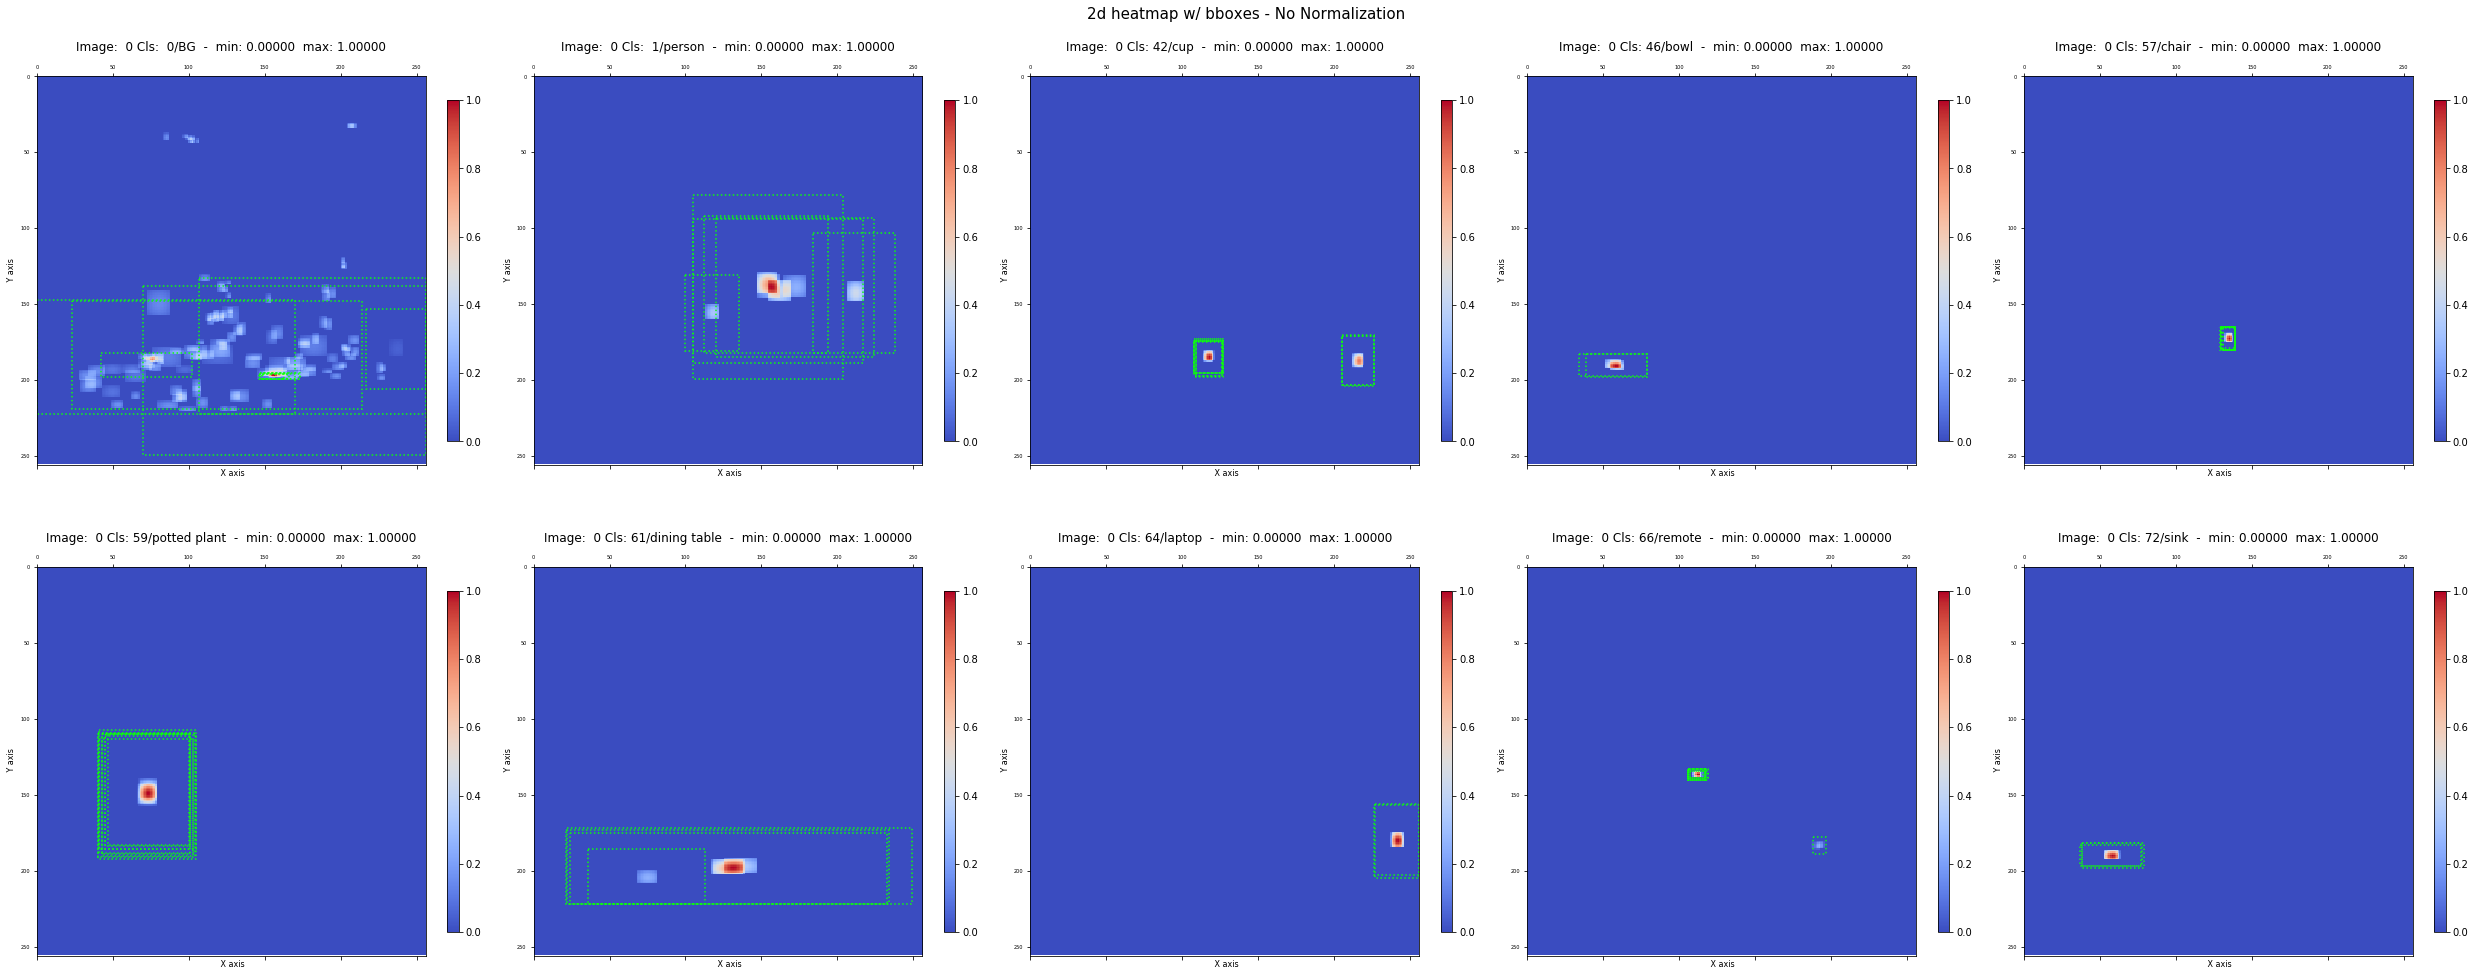

In [96]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(model_pred_heatmap.shape)
    print(model_pred_heatmap_scores.shape)
    print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
    plot_2d_heatmap_with_bboxes(model_pred_heatmap, model_pred_heatmap_scores, img_id, 
                                columns = 5, class_ids = pr_class_ids , class_names = class_names, scale = 4)   

####  2D plot of `pred_heatmap_norm` returned from model prediction: `res = predict(train_batch_x)`

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(res[0].shape, res[1].shape)
    class_ids = np.unique(res[1][img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    
    plot_2d_heatmap_with_bboxes(res[0], res[1], 
                                img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)

####  2D plot of `model_gt_heatmap_norm` returned from model

(1, 256, 256, 81)
Image : 0  ClassIds: [0, 42, 43, 46, 57, 59, 61, 63, 66]
 Image Id:  0  Display classes: [0, 42, 43, 46, 57, 59, 61, 63, 66]
 rows   2  columns : 5 boxes.shape :  (81, 200, 11)
 min_z_all shape: ()  min_z_all: 0.0  max_z_all: () max_z_all: 1.0
 min_z_cls shape: (1, 1, 81)  max_z_cls shape: (1, 1, 81)
 SCALING == none 


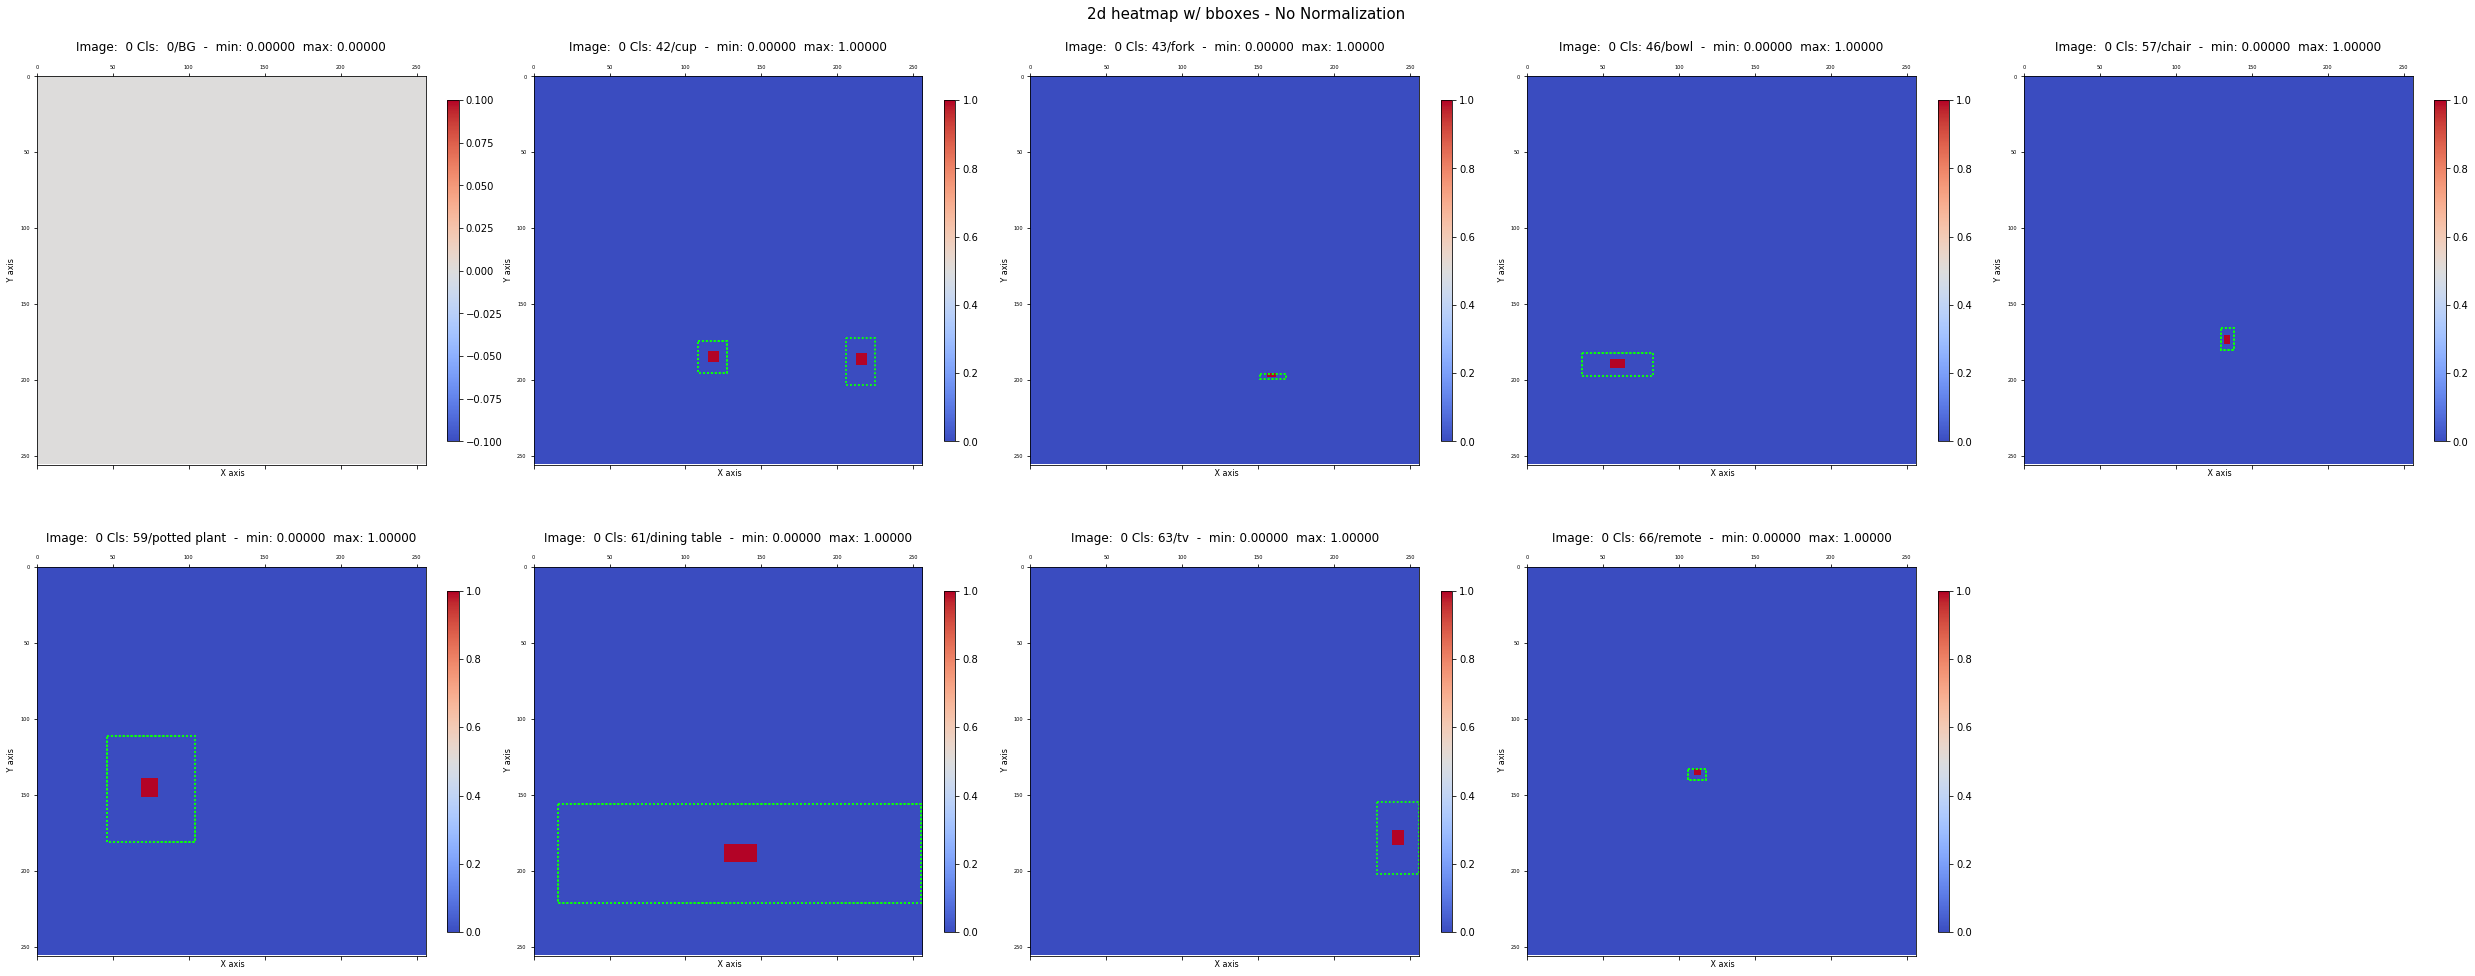

In [98]:
for img_id in [0]:     ##range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape)
    print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))
    plot_2d_heatmap_with_bboxes(model_gt_heatmap, model_gt_heatmap_scores, img_id,  
                                class_ids = gt_class_ids, columns= 5, class_names = class_names, scale = 4)

###  3D Plots

####  3D plot of `model_pred_heatmap_norm` returned form model

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_pred_heatmap_norm, img_id, class_ids, class_names = class_names)


####  3D plot of  `pred_heatmap_norm` returned form code above

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(pred_heatmap_norm.shape)
    class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(pred_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)

####  3D plot of  `model_gt_heatmap_norm` returned form code above

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_gt_heatmap, img_id, class_ids,  class_names = class_names)


####  3D plot of  `gt_heatmap_norm` returned form code above

In [ ]:
for img_id in [1]: ## range(mrcnn_config.BATCH_SIZE):
    print(gt_heatmap_norm.shape)
    class_ids = np.unique(gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(gt_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


#### Verfiy max and min of gaussian heatmaps are 1.0 and 0.0, respectively 

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
print(model_pred_heatmap_norm.shape)
hm_max = np.max(model_pred_heatmap_norm, axis = (1,2))
hm_min = np.min(model_pred_heatmap_norm, axis = (1,2))
print(hm_max.shape)
for img_id in range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('\n Image : {}  ClassIds: {}'.format(img_id, class_ids))
    print('-'*38)
    for cls in class_ids: 
        print(' class: {}   max: {}  min: {}'.format(cls, hm_max[img_id,cls], hm_min[img_id,cls]))
#         print(pred_heatmap_scores[img_id, cls])

print(model_gt_heatmap.shape)
hm_max = np.max(model_gt_heatmap, axis = (1,2))
hm_min = np.min(model_gt_heatmap, axis = (1,2))
print(hm_max.shape)
for img_id in range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('\n Image : {}  ClassIds: {}'.format(img_id, class_ids))
    print('-'*38)
    for cls in class_ids: 
        print(' class: {}   max: {}  min: {}'.format(cls, hm_max[img_id,cls], hm_min[img_id,cls]))
#         print(pred_heatmap_scores[img_id, cls])
        
     

###  Display `pred_scatter` heatmaps for all bounding boxes of an image

In [ ]:
%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 1
print(pred_heatmap_scores[img,0,0])
plot_bbox_heatmaps(gauss_scatt[img], pred_tensor[img], width = 15, height=25, num_bboxes=12)

###  Display `gauss_heatmap` heatmap (not normalized, normlized, L2 normalized)

In [ ]:

%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 0
print(pred_heatmap_scores[img,0,0])
# plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='Non-normalized')
plot_gaussian(pred_heatmap_norm[img,:,:,1],0, 
plot_one_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='normalized')
# plot_one_heatmap(pred_heatmap_L2norm[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='L2-normalized')
# plot_heatmaps(pred_heatmap, pred_heatmap_scores, width = 15, num_bboxes=12)

###  Display `gauss_heatmap` 3D heatmap (not normalized, normlized, L2 normalized)

In [ ]:
from mrcnn.visualize import plot_3d_heatmap
%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 1
print(pred_heatmap_scores[img,cls,:10])

ttl = 'Non-normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)

ttl = 'Normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)


###  Find maximum of gaussian distributions for the pred_heatmap
Potentially use this as our heatmap scores 
Found out that using MAX values from the class heatmap (currently generated from the pred_tensor that itself is generated form output_rois and mrcnn_class) is not a viable option, because mutlple max values tend to congreagate around the peak of the gaussian distribution. 
This is also the case for gt_heatmaps.
This will probably also be the case for the FCN output.

#### pred_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)

print(pred_hm.shape)
cls_hm = pred_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print(pred_hm_norm.shape)
cls_hm_norm = pred_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))


In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


#### gt_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
print(pred_hm.shape)
cls_hm = gt_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print('---- norm -----')
print(gt_hm_norm.shape)
cls_hm_norm = gt_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))



In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


In [ ]:
max_a = np.max(cls_pred_heatmap)
print(max_a.shape)

print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

print()

print(' covar ', covar_sqrd)
print(prob_b[35:50, 45:54])
max_b = np.max(prob_b)
print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

print('max a , max_b ', max_a, max_b, max_a/max_b)

##  `development build_heatmap_tf ()` 

### Generate Multivariate Normal Distribution from Pred_Tensor

`pred_tensor[:,:,:,1:7]`  == `[116.9736  21.8213  36.2715  45.6026   0.    0.9139   ]`


Detections returned by `detect()` routine:

`[[ 25.          18.          80.          72.           2.           0.99936014]
  [ 51.           3.         106.          71.           3.           0.99924326]`

### Prepare values to pass to build_gaussian_tf

In [ ]:
img = 1
max_score = np.max(mrcnn_class, axis = -1)
max_class = np.argmax(mrcnn_class, axis = -1)
print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
print('max class[',img,']\n',max_class[img])
print('max score[',img,']\n',max_score[img])
print(' mrcnn class.shape ',mrcnn_class.shape)
print('marcnn_classe[',img,',:]\n',mrcnn_class[1,:])
# print(output_rois[1])
 

####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
print('Image ', img , '/ Class 0 ------------')
print(pred_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(pred_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(pred_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(pred_tensor[img,3])


####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', gt_tensor.shape)
img = 1
print('Image ', img , '/ Class 0 ------------')
print(gt_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(gt_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(gt_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(gt_tensor[img,3])




### Plot heatmap produced by network `fcn_bilinear` and compare with `pred_gaussian`

In [ ]:
from mrcnn.visualize import plot_gaussian, plot_gaussian_2d
import matplotlib as plt

%matplotlib notebook
img = 2
cls = 2
image_id = input_image_meta[img,0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
Zout1 = pred_heatmap     # gt_gaussiam 
Zout2 = pred_heatmap_norm  # fcn_bilinear
Zout3 = pred_heatmap_L2norm  # fcn_bilinear

print(Zout1.shape, Zout2.shape)
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
print(pred_tensor[img,cls,:10])
print(pred_tensor.shape)
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')

width = 9
# for j in [cls] : #range(num_classes):
print(pred_heatmap_scores[img,cls,:10])
ttl = 'Pred_hm      - image :  {} class: {} '.format(img,j)
plot_gaussian_2d(Zout1[img,:,:,j], title = ttl, width = width)

ttl = 'pred_norm - image :  {} class: {} '.format(img,j)     
plot_gaussian_2d(Zout2[img,:,:,j], title = ttl, width = width)  

ttl = 'pred_norm_L2 - image :  {} class: {} '.format(img,j)     
plot_gaussian_2d(Zout3[img,:,:,j], title = ttl, width = width)  


from mrcnn.visualize import display_gt_bboxes, display_roi_proposals
model_info = [model, config, dataset_train, train_generator]
display_roi_proposals(model_info, input_image_meta, pred_tensor, [cls], 0)

In [ ]:
%matplotlib notebook
width = 12
plot_gaussian2([pred_heatmap_norm, fcn_heatmap_norm], image_idx = 0, title = ttl, width = width)  


###  Test `means`, `covar`, `gauss_grid`, and `gauss_sum ` between development version and final version

In [ ]:
print(means.get_shape(), means.get_shape())
tst1 = means.eval()
tst2 = means2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = st.eval()
tst2 = st2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = gauss_grid.eval()
tst2 = gauss_grid2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,0,:10])
print()
print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

In [ ]:
tst1 = gauss_sum.eval()
tst2 = gauss_sum2.eval()
print(tst1.shape, tst2.shape)

# print(tst1[0,0,:10])
# print()
# print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
from scipy.stats import  multivariate_normal
# Build mesh-grid to hold pixel coordinates ----------------------------------
XX = np.arange(0, img_w, 1)
YY = np.arange(0, img_h, 1)
XX, YY = np.meshgrid(XX, YY)
print('XX shape', XX.shape)
pos  = np.empty(XX.shape + (2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
pos[:,:,0] = XX;
pos[:,:,1] = YY;
print('XX')
print(XX)
print('YY')
print(YY)
print(pos[0,:,:])
print(pos[0])
print(grid[0].eval())
print(' pos type    ', type(pos), type(grid))
print(' grid shape ', pos.shape, grid.shape)
print(np.all(pos == grid.eval()))
mean = np.array([1,2])
covar = np.array([[1,0],[0,1]])
print(' mean  ', mean)
print(' covar ', covar)
mvna   = multivariate_normal(mean, covar)
prob_a = mvna.pdf(pos)

# mvnb = multivariate_normal(mean, covar_sqrd)
# prob_b = mvnb.pdf(pos)

# print(prob_a[35:50, 45:54])
# max_a = np.max(prob_a)
# print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

# print()

# print(' covar ', covar_sqrd)
# print(prob_b[35:50, 45:54])
# max_b = np.max(prob_b)
# print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

# print('max a , max_b ', max_a, max_b, max_a/max_b)

In [ ]:
with sess.as_default():
    #-----------------------------------------------------------------------------
    ## Build mesh-grid to hold pixel coordinates  
    #-----------------------------------------------------------------------------
    X = tf.range(80, dtype=tf.int32)
    Y = tf.range(80, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)

    # duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    ones = tf.ones([1, 1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

    # # stack the X and Y grids 
    bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
    print('    before transpse ', tf.shape(bef_pos).eval())
    pos_grid = tf.transpose(bef_pos,[1,2,0,3])
    print('    after transpose ', tf.shape(pos_grid).eval())    
    pt2_den = tf.constant([[10,10,30,70]], dtype = tf.float32)
    print(type(pt2_den))
    #-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    #-----------------------------------------------------------------------------
    width  = pt2_den[:,3] - pt2_den[:,1]      # x2 - x1
    height = pt2_den[:,2] - pt2_den[:,0]
    print(width.eval(), type(width))
    print(height.eval(), type(height))
    cx     = pt2_den[:,1] + tf.div( width  , 2.0)
    cy     = pt2_den[:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)
    print(means.eval())
    print(covar.eval())

    tfd = tf.contrib.distributions
    mvn = tfd.MultivariateNormalDiag( loc  = means,  scale_diag = covar)
    prob_grid = mvn.prob(pos_grid)
    print('     Prob_grid shape before tanspose: ',prob_grid.get_shape())
    prob_grid = tf.transpose(prob_grid,[2,0,1])
    print('     Prob_grid shape after tanspose: ',prob_grid.get_shape())    
    print('    >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.get_shape())
    print('    << output probabilities shape:' , prob_grid.get_shape())


## Plot Image with bounding boxes from `output_rois`

In [ ]:
img_idx = 0
image_id = input_image_meta[img_idx,0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
class_names = dataset_train.class_names
# visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
print('Classes     : ', class_ids)
print("image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
print(' class_ids    : ', class_ids.shape[0])
print(' bbox         : ', bbox.shape[0])
print(' output_rois: : ', output_rois.shape)
print(' Image id     : ', image_id , '  Image meta', img_meta[img_idx,:10])
print(' Classes      : ', [class_names[i] for i in class_ids])
print(' Image window : ', img_meta[0, 4:8])
print(' Image shape  : ', image.shape)


#### Display `output_roi` without  delta refinement

In [ ]:
unormalized_rois = output_rois[img_idx] * [1024,1024,1024,1024]
unrefined_rois   = utils.boxes_to_image_domain(unormalized_rois, img_meta[0] )
visualize.draw_rois(image, unrefined_rois, target_class_ids[0], class_names, limit=5) #, random = True)

#### Display `output_rois` with after clipping to image boundaries

In [ ]:
clipped_rois = utils.clip_to_window_np(img_meta[0, 4:8], unormalized_rois)
clipped_rois = utils.boxes_to_image_domain(clipped_rois, img_meta[0] )
visualize.draw_rois(image, clipped_rois , target_class_ids[0], class_names, bbox_ids = [0,1,2]) # or , limit=2)

####  Displayt `output_rois` after applying `target_bbox_deltas`

NOTE: MUST BE MULTIPLIED BY BBOX_STD_DEV

In [ ]:
print(' Target_bbox_deltas: ',target_bbox_deltas.shape)
## 1- Apply Bounding Box Standard Deviation and apply to output_rois
apply_deltas = target_bbox_deltas[img_idx] * mrcnn_config.BBOX_STD_DEV
refined_rois = utils.apply_box_deltas_np(output_rois[img_idx], apply_deltas)
print(' Refined ROIs shape: ',refined_rois.shape)
# print(refined_rois[:20])

## 3- Clip to image windoow boundaries:
refined_rois = refined_rois * [1024,1024,1024,1024]
refined_rois = utils.clip_to_window_np(img_meta[0, 4:8], refined_rois)

## 4- Transfer to image coordniates :
refined_rois = utils.boxes_to_image_domain(refined_rois, img_meta[0] )
## 5- Visualize
visualize.draw_rois(image, refined_rois, target_class_ids[0], class_names,bbox_ids = [0,1,2], limit=5)

#### Apply predicted `mrcnn_bbox` delta refinements to `output_rois` and display

In [ ]:
# Create un
unormalized_rois = output_rois[img_idx] * [1024,1024,1024,1024]
clipped_rois = utils.clip_to_window_np(img_meta[0, 4:8], unormalized_rois)
unrefined_rois   = utils.boxes_to_image_domain(clipped_rois, img_meta[0] )

## 1- Extract predicted deltas from mrcnn_bbox
classes, deltas = get_predicted_mrcnn_deltas(mrcnn_class, mrcnn_bbox, verbose = False)
# print(classes.shape, deltas.shape)
# print(classes[0,:20])
# print(deltas[0,:20])


## 2- Apply Bounding Box Standard Deviation and apply to output_rois
apply_deltas = deltas[0] * mrcnn_config.BBOX_STD_DEV
refined_rois = utils.apply_box_deltas_np(output_rois[img_idx], apply_deltas)
print(' Refined ROIs shape: ',refined_rois.shape)
# print(refined_rois[:20])

## 3- Clip to image windoow boundaries:
refined_rois = refined_rois * [1024,1024,1024,1024]
refined_rois = utils.clip_to_window_np(img_meta[0, 4:8], refined_rois)

## 4- Transfer to image coordniates :
refined_rois = utils.boxes_to_image_domain(refined_rois, img_meta[0] )

# Visualize
visualize.draw_rois(image, unrefined_rois, target_class_ids[0], class_names,  limit=5)
visualize.draw_rois(image, refined_rois, target_class_ids[0], class_names,  limit=5)
# visualize.draw_rois_with_refinements(image, unrefined_rois, refined_rois, target_class_ids[0], class_names, limit=10)

#### Display `image_gt_bboxes` provided by data generator

In [ ]:
# Display image and instances
# visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)   

# print(input_gt_bboxes[0,:20])
gt_bboxes = utils.boxes_to_image_domain(input_gt_bboxes[0], img_meta[0] )
visualize.draw_rois(image, gt_bboxes[:20], input_gt_class_ids[0,:20], class_names, limit=10)

## misc code

#### sparse to dense

In [ ]:
with sess.as_default():
    tf_dense = tf.sparse_to_dense(pt2_ind), in_tensor.shape[:-1], 1,0)
    r_tf_dense = tf_dense.eval()
print(r_tf_dense.shape)    
print(r_tf_dense[0])


####  Display for visual check - `pred_heatmap_norm` is the final result from  `build_heatmap()`

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6, suppress=True)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
for img in [0,1,2]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(np.min(pred_heatmap_scores[img,k,:,8]))
        print(pred_heatmap_scores[img,k])

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_heatmap_scores shape is ', gt_heatmap_scores.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_heatmap_scores[img,k])

In [ ]:
sess = KB.get_session()
with sess.as_default():
    temp = fcn_heatmap
    np.set_printoptions(linewidth=150, threshold=10000)
    print('  output shapes :',  temp.get_shape())
    temp_sum = tf.reduce_sum(temp, [2,3])
    temp_min = tf.reduce_min(temp, [2,3])
    temp_max = tf.reduce_max(temp, [2,3])
    temp_avg = tf.reduce_mean(temp, [2,3])
    print('temp_sum is ', temp_sum.shape)
    for i in range(5):
        for j in range(4):
                print('img/cls ',i,'/', j,'  sum:',temp_sum[i,j], 'min',temp_min[i,j] ,'max',temp_max[i,j] ,'avg',temp_avg[i,j])

#### `byclas_to_byimage()` reshape tensor / numpy array from per_class to per image 

In [ ]:
def byclass_to_byimage_np(in_array, seqid_column):    
    ''' 
    convert a by class tensor shaped  [batch_size, num_classes, num_bboxes, columns ] to 
            a by image tensor shaped  [batch_size, num_bboxes, columns]
    '''
    #     np_sum = np.sum(np.abs(model_gt_heatmap_scores[:,:,:,0:4]), axis=-1)
    #     print(np_sum.shape)
    #     a,b,c = np.where(np_sum > 0)
    a,b,c = np.where(in_array[...,seqid_column]>0)

    output = np.zeros((in_array.shape[0],in_array.shape[-2],in_array.shape[-1]))
#     print(' output shape is ',output.shape)
#     print(a.shape, b.shape,c.shape)
    
    for img, cls , box in zip(a, b,c):
#         print( img,cls, box, 200 - in_array[img, cls, box,6].astype(int))
        output[img, 200 - in_array[img, cls, box,6].astype(int)] = in_array[img, cls, box]

    return output

def byclass_to_byimage_tf(in_array, seqid_column):    
    ''' 
    convert a by class tensor shaped  [batch_size, num_classes, num_bboxes, columns ] to 
            a by image tensor shaped  [batch_size, num_bboxes, columns]
    '''
    aa = tf.reshape(in_array, [in_array.shape[0], -1, in_array.shape[-1]])
    _ , sort_inds = tf.nn.top_k(tf.abs(aa[:,:,seqid_column]), k= in_array.shape[2])
    batch_grid, bbox_grid = tf.meshgrid(tf.range(in_array.shape[0]), tf.range(in_array.shape[2]),indexing='ij')
    gather_inds = tf.stack([batch_grid, sort_inds],axis = -1)
    output = tf.gather_nd(aa, gather_inds )
    return output

####  Try `byclass_to_byimage()` on `gt_heatmap_scores`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print(gt_heatmap_scores.shape)
# outp = byclass_to_byimage_tf(gt_heatmap_scores,6)
# with sess.as_default():
#      r_outp = outp.eval()
# print(r_outp.shape)
# print(r_outp[0])
# print(r_outp[1])


# print(tf_model_pred_heatmap_scores.shape, tf_model_pred_heatmap_scores)
# outp = byclass_to_byimage_tf(tf_model_pred_heatmap_scores,6)
# with sess.as_default():
#      r_outp = outp.eval()
# print(r_outp.shape)
# print(r_outp[0])
# print(r_outp[1])

####  Try `byclass_to_byimage()` on `pred_heatmap_scores`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)

tf_model_pred_heatmap_scores = tf.constant(model_pred_heatmap_scores) 

print('pred_heatmap_scores shape is       ', pred_heatmap_scores.shape )
print('pred_heatmap_scores from model is :', tf_model_pred_heatmap_scores.shape,tf_model_pred_heatmap_scores)
r_out2 = byclass_to_byimage_np(pred_heatmap_scores,6)

with sess.as_default():
    r_out1 = byclass_to_byimage_tf(tf_model_pred_heatmap_scores,6).eval()

for img in range(2):
    class_ids = np.unique(pred_heatmap_scores[img,:,:,4]).astype(int).tolist()    
    print('Classids: ', class_ids)
    print('Image ', img ,' ------------')
    for j in range(200):
        print('tf: ',r_out1[img,j])
        print('np: ',r_out2[img,j])
        print()

#### ground work for writing `byclass_to_by_image()`

In [ ]:
# print(pred_heatmap_scores.shape)
# gt_heatmap_scores = tf.identity(model_gt_heatmap_scores)
# aa = tf.reshape(gt_heatmap_scores, [gt_heatmap_scores.shape[0], -1, gt_heatmap_scores.shape[-1]])
# _ , sort_inds = tf.nn.top_k(tf.abs(aa[:,:,6]), k=gt_heatmap_scores.shape[2])
# print(sort_inds.shape)
# batch_grid, bbox_grid = tf.meshgrid(tf.range(batch_size), tf.range(gt_heatmap_scores.shape[2]),indexing='ij')
# gather_inds = tf.stack([batch_grid, sort_inds],axis = -1)
# print(aa.shape)
# print(bb.shape)
# cc = tf.gather_nd(aa, gather_inds )
# print('cc : ',cc.shape)
# with sess.as_default():
# #     r_pred_heatmap_scores = gauss_scores.eval()
#     r_aa = aa.eval()
#     r_sort_inds = sort_inds.eval()
#     r_gather_inds = gather_inds.eval()
# #     r_bb = bb.eval()
#     r_cc = cc.eval()
# #     r_dd = dd.eval()
# # print(r_pred_heatmap_scores[0,1])
# print('cc: ',r_cc.shape)
# print('bb: ',r_bb.shape)
# print('aa: ',r_aa.shape)
# # print(r_sort_inds)
# print(r_gather_inds)
# # print(r_bb)
# print(r_cc[0])
print(r_cc[1])

####  Convert `pred_heatmap_scores` using `byclass_to_byimage_np`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print(model_pred_heatmap_scores.shape)
print(model_pred_heatmap_scores[0,0,0])
outp = byclass_to_byimage_np(model_pred_heatmap_scores,6)
print(outp[0])

####  Convert `gt_heatmap_scores` using `byclass_to_byimage_np`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)

# print('pred_heatmap_scores shape is       ', gt_heatmap_scores.shape )
print('pred_heatmap_scores from model is :', model_gt_heatmap_scores.shape)
print(model_gt_heatmap_scores[0,1])

# with sess.as_default():
#     r_pred_tensor = pred_tensor.eval()
# for img in range(2):
#     class_ids = np.unique(model_gt_heatmap_scores[img,:,:,4]).astype(int).tolist()    
#     print('Classids: ', class_ids)
#     for i in class_ids:
#         print('Image ', img , '/ Class ',i,' ------------')
#         for j in range(200):
#             print(gt_heatmap_scores[img,i,j])
#             print(model_gt_heatmap_scores[img,i,j])
# #         print(pred_refined_tensor[img,i,j])
#         print()
 
outp = byclass_to_byimage_np(model_gt_heatmap_scores,6)
print(outp[0])

####  Display for visual check - `pred_heatmap_scores`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_heatmap_scores[img,k])

####  Display for visual check - `pred_heatmap_norm`  

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
            print('img ',i,' class ', j, ' sum:',temp_sum[i,j])

####  Run TF graph

In [ ]:
# with sess1.as_default():
# FeedList = [positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_class_ids, roi_gt_boxes, roi_gt_box_assignment ]
# FeedList = [ rois, roi_gt_class_ids,  roi_gt_deltas, roi_gt_boxes]
Fetches  = [ pred_heatmap, pred_heatmap_norm, pred_heatmap_scores]
tt = sess.run(Fetches)
print(type(tt), len(tt))
for i in tt:
    print(type(i), i.shape)